# Notebook 26: CO Core Mass

In this notebook we hope to find out CHE is efficient at producing a pile-up of $35\,\mathrm{M}_\odot$ BHs under some particular setting for our wind model.

In [1]:
# nb_id is used to identify this notebook's output files (i.e., figures) if there are any
# it should match the first two digits in the notebook's title
nb_id = 26

## Imports

In [2]:
from pathlib import Path
from math import isnan

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

import astropy.units as u
import astropy.constants as ct
from scipy.signal import find_peaks

import mesa_reader as mr
import mesaPlot as mp
import tulips as tp

import sys
sys.path.append('..')
from src.star import fix_unit, eggleton_rl1_radius, a_from_p, p_from_a, marchant_l2_radius

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [3]:
ROOT = Path.cwd().parent
PROJECT_FOLDER = ROOT/'mesa/sse_HeExh_test'
FIGURE_FOLDER = Path(f'./output/nb{nb_id}/figures')
FIGURE_FOLDER.mkdir(parents=True, exist_ok=True)

In [4]:
plt.style.use('./plotstyle.mplstyle')

## Definitions

### Constants

In [5]:
ZSUN = 0.014

### Utilities

In [6]:
def savefig(fig, fname):
    """Saves png, pdf and eps figure files to a nb-specific folder."""
    fname = f'nb{nb_id}_{fname}'
    plt.savefig(FIGURE_FOLDER/(fname+'.png'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.pdf'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.eps'), bbox_inches='tight')

In [7]:
def normarr(arr):
    return (arr-min(arr))/(max(arr)-min(arr))

In [8]:
def get_model_folder(model_id, verbose=True):
    """Finds model folder given its id."""
    matches = list(PROJECT_FOLDER.glob(f'{model_id}_*'))
    
    if len(matches) > 1:
        if verbose:
            print('\n'.join((
                f'Multiple matches for id {model_id} found in {PROJECT_FOLDER}:',
                *[str(match) for match in matches]
            )))
        return
    elif len(matches) != 0:
        match = matches[0]
        if verbose:
            print(f'Found match {match}')
        return match
    else:
        if verbose:
            print(f'No matches found in {PROJECT_FOLDER}')
        return           

In [9]:
def get_model_dict(grid_folder):
    """Given a model folder, loads the paths of specific stars into a 
    m1, p_orb dictionary."""
    d = dict()
    for model_folder in grid_folder.glob('m*_w*'):
        if model_folder.suffix == '.log':
            continue
        m, w = model_folder.name.replace('d', 'e').split('_')        
        m = f'{float(m.lstrip("m")):.1f}'
        w = float(w.lstrip('w'))
        p = 2*np.pi / w / (60*60*24)
        p = f'{p:.2f}'
        if m not in d.keys():
            d[m] = dict()
        d[m][p] = model_folder
    return d

In [10]:
def mesareader_operator(expression):
    """Converts strings into operations between mesareader columns.
    
    Supports summation, subtraction, multiplication, division and exp10."""
    operations = ['+', '-', '*', '/', '^', 'E', '(', ')']
    
    mr_expression = ''
    attr = ''
    char_i = 0
    while char_i < len(expression):
        char = expression[char_i]
        if char not in operations:
            mr_expression += f'h.__getattr__("{char}'
        else:
            if char == '^':
                char = '10**'
            elif char == 'E':
                char = 'e_scattering_edd_l('
            mr_expression += f'{char}h.__getattr__("'
        char_i += 1
        char = expression[char_i]
        while char not in operations+['']:
            attr += char
            char_i += 1
            try:
                char = expression[char_i]
            except IndexError:
                char = ''
        if char == '^':
            char = '10**'
        elif char == 'E':
                char = 'e_scattering_edd_l('
        attr = f'{attr}"){char}'
        mr_expression += attr
        attr = ''
        char_i += 1
            
    return mr_expression


In [11]:
mesareader_operator('^log_L/Estar_mass)')

'10**h.__getattr__("log_L")/e_scattering_edd_l(h.__getattr__("star_mass"))'

### Plotting

In [12]:
def history_plot(ax, model_dict_list, model_styles, model_labels, x, y, invert_xaxis, invert_yaxis, title=False,
                 label_period=True):
    """2D line plot for all m1, p_orb combinations from a given model.
    
    Assumes a single m1 per dict.
    """
    
    #base_dict = model_dict_list[0]
    #all_paths = [base_dict[k1][k2] for k1 in base_dict.keys() for k2 in base_dict[k1].keys()] 
    
    all_periods = []
    for dict_ in model_dict_list:
        for k1 in dict_.keys():
            for k2 in dict_[k1].keys():
                all_periods.append(k2)
    all_periods = np.unique(all_periods)
    all_periods = all_periods[np.argsort([float(p) for p in all_periods])]
    
    period_color_dict = {}
    for i, p in enumerate(all_periods):
        period_color_dict[p] = cm.jet(i/len(all_periods))
    
    handles = []
    for p_key in all_periods:
        p = float(p_key)
        c = period_color_dict[p_key]
        
        if label_period:
            label = f'${p:.2f}\\,\\mathrm{{d}}$'
        else:
            label = None
        handles.append(Line2D([], [], ls='-', color=c, label=label))
               
        for dict_, ls in zip(model_dict_list, model_styles):
            dict_ = dict_[list(dict_.keys())[0]]
            try:
                model_path = dict_[p_key]
                h = mr.MesaData(str(model_path/'LOGS/history.data'))
            except:
                print(f'Model {model_path} failed to load.')
                continue
            else:
                x_data = eval(mesareader_operator(x))
                y_data = eval(mesareader_operator(y))
                ax.plot(x_data, y_data, ls=ls, color=c, lw=1)
                
    if invert_xaxis:
        ax.invert_xaxis()
    if invert_yaxis:
        ax.invert_yaxis()
    
    if title:
        ax.set_title(model_labels[0], fontsize=20)
    #else:
        #for ls, label in zip(model_styles, model_labels):
         #   handles.append(Line2D([], [], color='k', ls=ls, label=label))
    if label_period:
        ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))
    
    return ax

### Winds

In [13]:
def _sanders_winds(l, t, z):
    logz = np.log10(z/ZSUN)
    alpha = 0.32 * logz + 1.4
    l0 = 10.**(-0.87*logz + 5.06)
    mdot10 = 10.**(-0.75*logz - 4.06)
    
    if l <= l0:
        log_power_term = 0
    else:
        log_power_term = np.log10(l/l0) ** alpha
              
    w = mdot10 * log_power_term * (l/(10*l0))**0.75
    
    if t > 1.41e5 and l > l0:
        log_w = np.log10(w) - 6*np.log10(t/1.41e5)
        w = 10.**log_w
    return w

def _vink2017_winds(l, z):
    log_mdot = - 13.3 + 1.36*np.log10(l) + 0.61*np.log10(z/ZSUN)
    return 10.**log_mdot

def _vink2001_winds(l, t, m, z):
    Teff_jump = 1e3*(61.2 + 2.59*(-13.636 + 0.889*np.log10(z/ZSUN)))
    
    if t > 27.5e3:
        a = 1
    elif t < 22.5e3:
        a = 0
    else:
        dt = 100
        if t > Teff_jump + dt:
            a = 1
        elif t < Teff_jump - dt:
            a = 0
        else:
            a = (t - (Teff_jump - dt)) / (2*dt)
    
    if a > 0:
        vinf_div_vesc = 2.6
        vinf_div_vesc = vinf_div_vesc * (z/ZSUN)**0.13
        log_mdot = (
            - 6.697
            + 2.194 * np.log10(l/1e5)
            - 1.313 * np.log10(m/3e1)  
            - 1.226 * np.log10(vinf_div_vesc/2e0)              
            + 0.933 * np.log10(t/4e4) 
            - 10.92 * np.log10(t/4e4)**2
            + 0.85 * np.log10(z/ZSUN)
            )
        mdot1 = 10.**log_mdot
    else:
        mdot1 = 0
        
    if a < 1:
        vinf_div_vesc = 1.3    
        vinf_div_vesc = vinf_div_vesc * (z/ZSUN)**0.13
        log_mdot = (
            - 6.688 
            + 2.210 * np.log10(l/1e5) 
            - 1.339 * np.log10(m/3e1) 
            - 1.601 * np.log10(vinf_div_vesc/2)
            + 1.07 * np.log10(t/2e4) 
            + 0.85 * np.log10(z/ZSUN)
            )
        mdot2 = 10.**log_mdot
    else:
        mdot2 = 0
        
    w = a*mdot1 + (1-a)*mdot2  
    return w


In [14]:
vink2001_winds = np.vectorize(_vink2001_winds)
vink2017_winds = np.vectorize(_vink2017_winds)
sanders_winds = np.vectorize(_sanders_winds)

In [15]:
vink2001_test_teffs = np.logspace(3, 6, 100)
vink2001_test_mdots = vink2001_winds(1e6, vink2001_test_teffs, 60, ZSUN)

In [16]:
def _winds(l, t, m, z, y):
    
    v01 = vink2001_winds(l, t, m, z)
    v17 = vink2017_winds(l, z)
    s23 = sanders_winds(l, t, z)
    
    he_w = max(v17, s23)
    
    if y < 0.4:
        y_weight = 0
    elif y < 0.7:
        y_weight = (y - 0.4)/0.3
    else:
        y_weight = 1
        
    w = y_weight * he_w + (1-y_weight) * v01
    
    return w
    

In [17]:
winds = np.vectorize(_winds)

## HR diagram

In [18]:
def log_l_const_rad(log_teff, r):
    teff = 10.**log_teff * u.K
    r = fix_unit(r, u.Rsun)
    log_l = np.log10(4*np.pi*ct.sigma_sb * teff**4 * r**2 / u.Lsun)
    return log_l
log_l_const_rad = np.vectorize(log_l_const_rad)

In [19]:
def hd_limit(log_teff):
    teff = 10**log_teff * u.K
    log_l = (
        np.log10(1.e5*np.sqrt(4*np.pi))
        + 0.5*np.log10(ct.sigma_sb * u.Rsun**2 * teff**4 / u.Lsun)
    ).value
    log_l = max(log_l, np.log10(6.e5))
    return log_l
hd_limit = np.vectorize(hd_limit)

In [20]:
def hr_diagram_tracks(
    ax,
    models_to_plot,
    model_style_list,
    xlim, 
    ylim,
    legend=True,
    labelx=True, 
    labely=True
    ):
    model_dict_list = model_dicts[models_to_plot]
    model_label_list = model_labels[models_to_plot]
    
    settings = dict(
        x='log_Teff',
        y='log_L',
        invert_xaxis=True,
        invert_yaxis=False,
        model_dict_list=model_dict_list,
        model_styles=model_style_list,
        model_labels=model_label_list,
        label_period=legend
        )

    ax = history_plot(ax, **settings)

    if labelx:
        ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
    if labely:
        ax.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')

    # GUIDELINES

    ## Humphreys-Davidson limit and LBV regime
    hd_x = np.linspace(*xlim, 100)
    hd_y = hd_limit(hd_x)
    ax.plot(hd_x, hd_y, 'k--', lw=1)
    ax.fill_between(hd_x, hd_y, [ylim[1]]*len(hd_y), color='k', alpha=0.05)

    ## Lines of constant radius
    r_to_plot = np.concatenate((np.arange(1, 10, 1), np.arange(10, 40, 10)))
    for i, r in enumerate(r_to_plot):
        r_y = log_l_const_rad(hd_x, r)
        ax.plot(hd_x, r_y, 'k--', lw=0.5, alpha=0.5)
        
        # label every two lines
        if not i%2:
            rotation = -np.arctan((r_y[1]-r_y[0])/(hd_x[1]-hd_x[0]))/np.pi*180       
            r_y_ = r_y[(hd_x >= xlim[1]) & (hd_x <= xlim[0])]
            y = r_y_[np.argmin(np.abs(r_y_-ylim[1]))]     
            x = hd_x[np.argmin(np.abs(r_y-y))]
            ax.text(
                x, 
                y,
                f'${r}\\,\\mathrm{{R}}_\\odot$',
                rotation=rotation,
                ha='left',
                va='top', 
                fontsize=10,
                alpha=0.8
                )
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    return ax

In [21]:
def e_scattering_edd_l(m):
    m = fix_unit(m, u.Msun)
    k = 0.4 * u.cm**2 /u.g
    l = 4*np.pi*ct.c*ct.G*m/k
    l = l.to(u.Lsun)
    return l.value

In [22]:
def hre_diagram_tracks(
    ax,
    models_to_plot,
    model_style_list,
    xlim, 
    ylim,
    legend=True,
    labelx=True, 
    labely=True
    ):
    model_dict_list = model_dicts[models_to_plot]
    model_label_list = model_labels[models_to_plot]
    
    settings = dict(
        x='log_Teff',
        y='^log_L/Estar_mass)',
        invert_xaxis=True,
        invert_yaxis=False,
        model_dict_list=model_dict_list,
        model_styles=model_style_list,
        model_labels=model_label_list,
        label_period=legend
        )

    ax = history_plot(ax, **settings)

    if labelx:
        ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
    if labely:
        ax.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    return ax

### Final properties

In [23]:
def get_core_mass_spin_w(logs, iso):
    central_iso_arr = [logs.profile_data(profile_number=n).__getattr__(iso)[-1] for n in logs.profile_numbers]
    max_iso_i = np.argmax(central_iso_arr)
    core_prof = logs.profile_data(profile_number=logs.profile_numbers[max_iso_i])
    core_edge_index = np.where(np.abs(core_prof.__getattr__(iso)-core_prof.__getattr__(iso)[-1]) <= 0.01)[0][0]
    core_mass = core_prof.mass[core_edge_index]
    core_am = 10**core_prof.log_J_inside[core_edge_index]
    core_w = core_prof.omega[core_edge_index]
    core_spin = (ct.c.cgs * core_am * u.g*u.cm**2/u.s / (ct.G.cgs * (core_mass * ct.M_sun.cgs)**2 )).to(u.dimensionless_unscaled).value
    return core_mass, core_spin, core_w

In [24]:
class WindIntegrator:
    
    def __init__(self, model_path, q0=1) -> None:
        self.h = mr.MesaData(str(model_path/'LOGS/history.data'))
        self.logs = mr.MesaLogDir(str(model_path/'LOGS'))
        self.time = self.h.star_age
        self.mdot = -10.**self.h.log_abs_mdot
        self.w0 = self.h.surf_avg_omega[np.where(self.h.surf_avg_omega > 0)[0][0]]
        self.p0 = 2*np.pi/self.w0 * u.s.to(u.d)
        self.q0 = q0
        
    @staticmethod
    def a_from_p(p, m, q):
        p = fix_unit(p, u.d)
        m = fix_unit(m, u.Msun)
        a = np.cbrt(ct.G * (1+q) * m / (4*np.pi**2) * p**2)
        a = a.to(u.Rsun).value
        return a
        
    @staticmethod
    def p_from_a(a, m, q):
        a = fix_unit(a, u.Rsun)
        m = fix_unit(m, u.Msun)
        p = np.sqrt(4 * np.pi**2 / (ct.G * (1+q) * m) * a**3)
        p = p.to(u.d).value
        return p
    
    def integrate(self, t_target):
        m = self.h.star_mass[0]
        p = self.p0
        q = self.q0
        a = self.a_from_p(p, m, q)
        
        i = 0
        t0 = self.time[i]
        t1 = self.time[i+1]
        mdot = self.mdot[i]
        while t1 < t_target:
            dm = mdot*(t1-t0)
            da = -2/(1+q) * dm/m
            dq = 0
            
            m += dm
            a += da
            q += dq
            p = self.p_from_a(a, m, q)
            
            i += 1
            try:
                t1 = self.time[i+1]   
            except:
                print(f'Reached end of model at t={t1/1e6:.2f} Myr')
                break
            else:
                t0 = self.time[i]
                mdot = self.mdot[i]
        
        return m, p, a, q
    
    @staticmethod
    def p_from_s(s, m):
        j = (ct.G.cgs * (m * u.Msun)**2 * s / ct.c.cgs).to(u.s).value
        return p
    
    def get_final_core_mps(self):
        core_m, core_s, core_w = get_core_mass_spin_w(self.logs, iso='o16')
        core_p = 2*np.pi/core_w * u.s.to(u.d)
        return core_m, core_p, core_s

# Analysis

For now we only have models with mass variations, where all other settings fixed. These are $\delta_\mathrm{mesh}=1$, $Z=\mathrm{Z}_\odot/10$, $Y_0=0.4$ and $\delta Y=0.3$.

In [64]:
model_ids = ['08', '07', '00', '01', '02', '03', '04', '05', '06', '09', '011', '012', '013']
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([
    '$20\,\\mathrm{M}_\\odot$',
    '$30\,\\mathrm{M}_\\odot$',
    '$40\,\\mathrm{M}_\\odot$',
    '$50\,\\mathrm{M}_\\odot$',
    '$60\,\\mathrm{M}_\\odot$',
    '$70\,\\mathrm{M}_\\odot$',
    '$80\,\\mathrm{M}_\\odot$',
    '$90\,\\mathrm{M}_\\odot$',
    '$100\,\\mathrm{M}_\\odot$',
    '$150\,\\mathrm{M}_\\odot$',
    '$200\,\\mathrm{M}_\\odot$',
    '$250\,\\mathrm{M}_\\odot$',
    '$300\,\\mathrm{M}_\\odot$'
])

Found match /mnt/home/ldesa/repos/cher/mesa/sse_HeExh_test/08_md1_m20_01zsun_04y0_03dy_HeExh
Found match /mnt/home/ldesa/repos/cher/mesa/sse_HeExh_test/07_md1_m30_01zsun_04y0_03dy_HeExh
Found match /mnt/home/ldesa/repos/cher/mesa/sse_HeExh_test/00_md1_m40_01zsun_04y0_03dy_HeExh
Found match /mnt/home/ldesa/repos/cher/mesa/sse_HeExh_test/01_md1_m50_01zsun_04y0_03dy_HeExh
Found match /mnt/home/ldesa/repos/cher/mesa/sse_HeExh_test/02_md1_m60_01zsun_04y0_03dy_HeExh
Found match /mnt/home/ldesa/repos/cher/mesa/sse_HeExh_test/03_md1_m70_01zsun_04y0_03dy_HeExh
Found match /mnt/home/ldesa/repos/cher/mesa/sse_HeExh_test/04_md1_m80_01zsun_04y0_03dy_HeExh
Found match /mnt/home/ldesa/repos/cher/mesa/sse_HeExh_test/05_md1_m90_01zsun_04y0_03dy_HeExh
Found match /mnt/home/ldesa/repos/cher/mesa/sse_HeExh_test/06_md1_m100_01zsun_04y0_03dy_HeExh
Found match /mnt/home/ldesa/repos/cher/mesa/sse_HeExh_test/09_md1_m150_01zsun_04y0_03dy_HeExh
Found match /mnt/home/ldesa/repos/cher/mesa/sse_HeExh_test/011_md1_m

Let's check the stellar models available.

In [60]:
print('Available models:')
for i in range(len(model_ids)):
    print(f'\t{model_folders[i]}:')
    keys1 = list(model_dicts[i].keys())
    keys1 = np.array(keys1)[np.argsort([float(key) for key in keys1])]
    for key1 in keys1:
        keys2 = list(model_dicts[i][key1].keys())
        keys2 = np.array(keys2)[np.argsort([float(key) for key in keys2])]
        print(f'\t\t(m1/msun) {key1}:')
        for key2 in keys2:
            print(f'\t\t\t(p_orb/d) {key2}')

Available models:
	/mnt/home/ldesa/repos/cher/mesa/sse_HeExh_test/07_md1_m30_01zsun_04y0_03dy_HeExh:
		(m1/msun) 30.0:
			(p_orb/d) 0.48
			(p_orb/d) 0.61
			(p_orb/d) 0.73
			(p_orb/d) 0.80
			(p_orb/d) 0.90
			(p_orb/d) 1.00
			(p_orb/d) 1.10
			(p_orb/d) 1.19
			(p_orb/d) 1.30
			(p_orb/d) 1.40
			(p_orb/d) 1.52
			(p_orb/d) 1.62
	/mnt/home/ldesa/repos/cher/mesa/sse_HeExh_test/08_md1_m20_01zsun_04y0_03dy_HeExh:
		(m1/msun) 20.0:
			(p_orb/d) 0.48
			(p_orb/d) 0.61
			(p_orb/d) 0.73
			(p_orb/d) 0.80
			(p_orb/d) 0.90
			(p_orb/d) 1.00
			(p_orb/d) 1.10
			(p_orb/d) 1.19
			(p_orb/d) 1.30
			(p_orb/d) 1.40
			(p_orb/d) 1.52
			(p_orb/d) 1.62
	/mnt/home/ldesa/repos/cher/mesa/sse_HeExh_test/00_md1_m40_01zsun_04y0_03dy_HeExh:
		(m1/msun) 40.0:
			(p_orb/d) 0.48
			(p_orb/d) 0.61
			(p_orb/d) 0.73
			(p_orb/d) 0.80
			(p_orb/d) 0.90
			(p_orb/d) 1.00
			(p_orb/d) 1.10
			(p_orb/d) 1.19
			(p_orb/d) 1.30
			(p_orb/d) 1.40
			(p_orb/d) 1.52
			(p_orb/d) 1.62
	/mnt/home/ldesa/repos/cher/mes

### The effect of mass

Let's first look at the evolution of our systems in the HR diagram.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


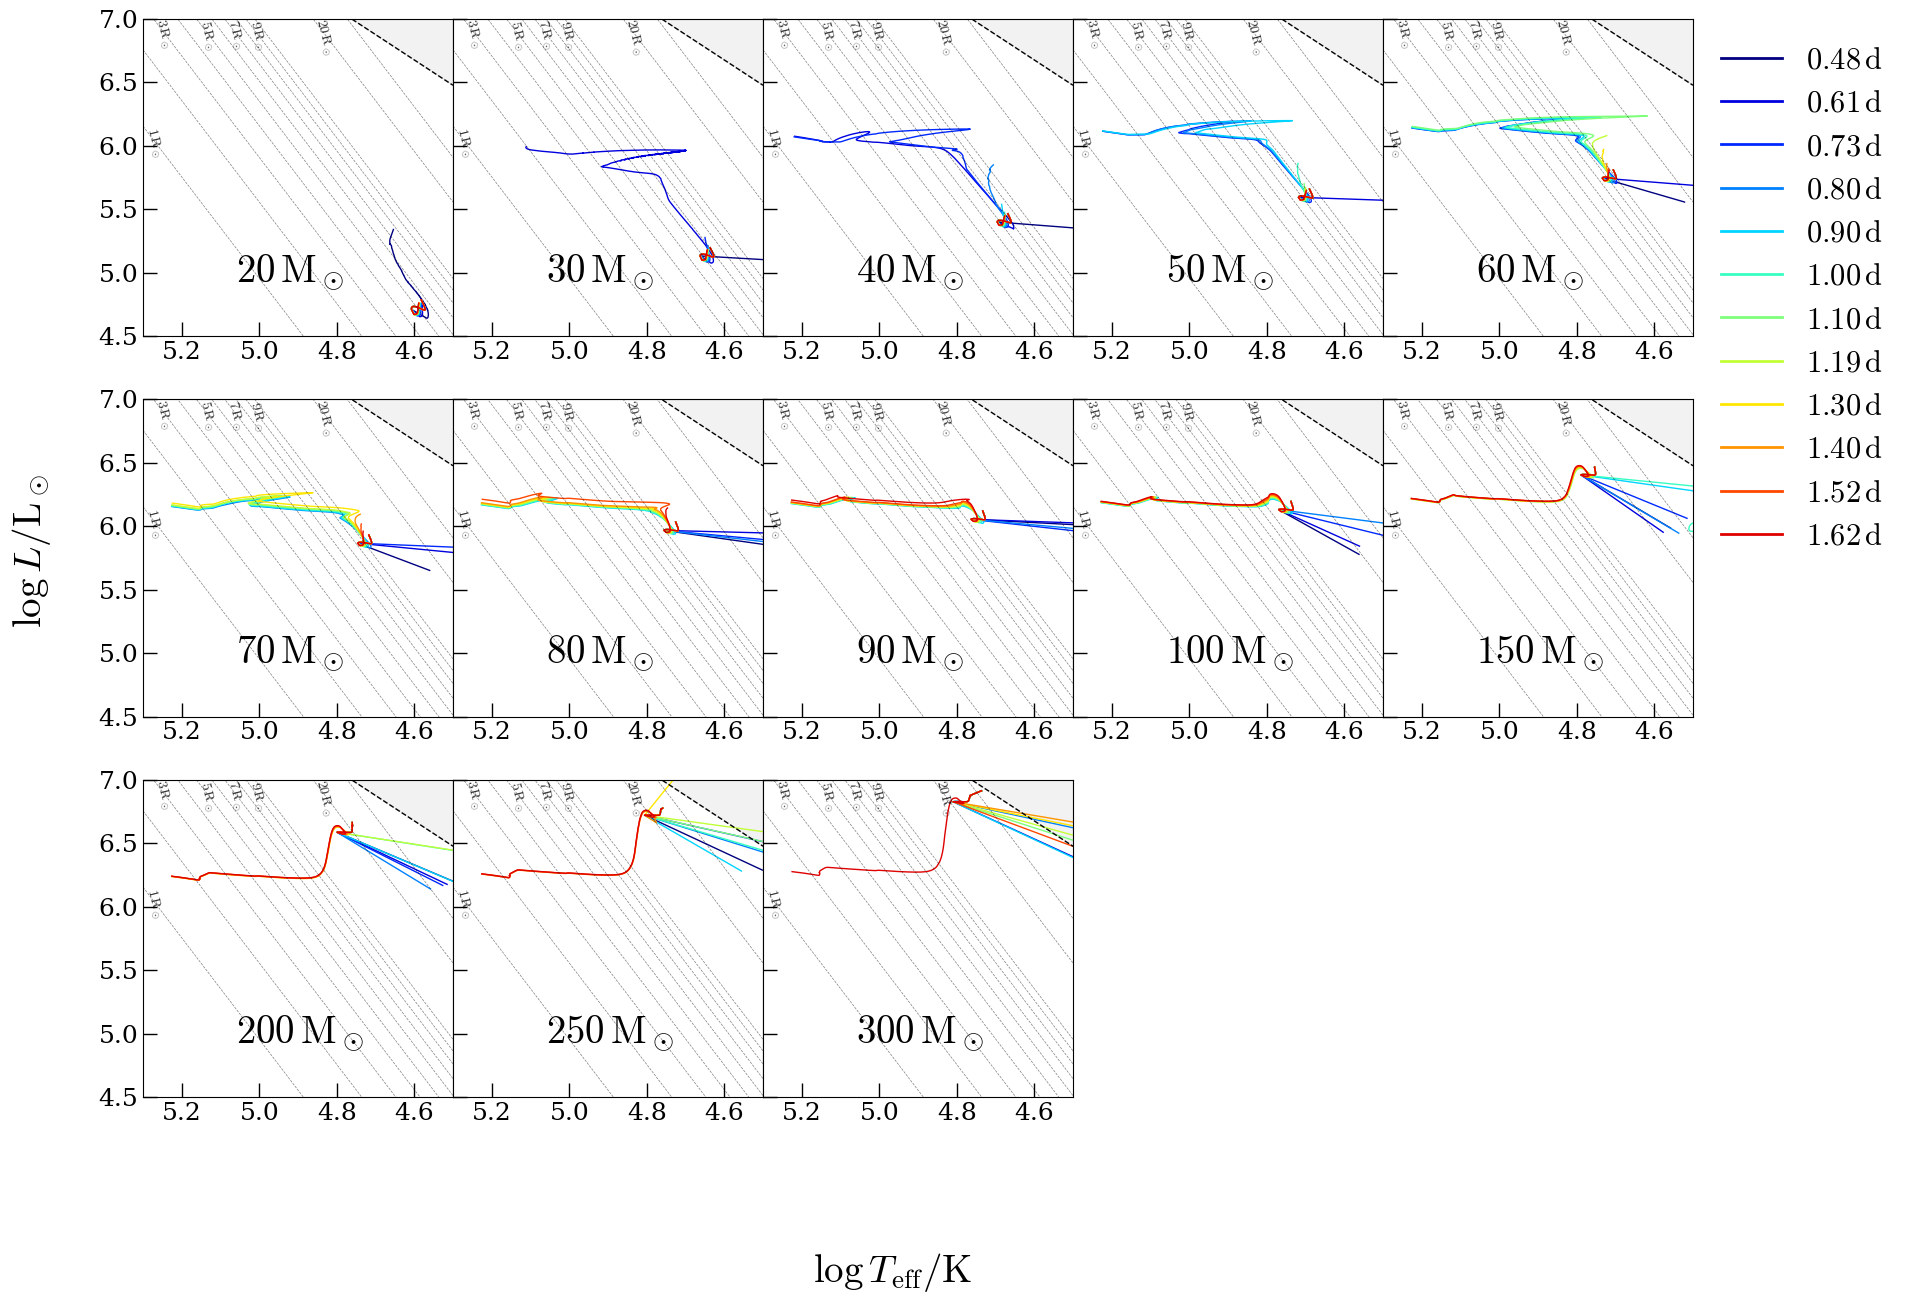

In [66]:
fig, axes = plt.subplots(3, 5, figsize=(20, 14))
axes = axes.flatten()
fig.subplots_adjust(wspace=0)

xlim = (5.3, 4.5)
ylim = (4.5, 7.0)

# PLOT M=20
ax = axes[0]
models_to_plot = [0]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(0.3, 0.2, '$20\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=50
ax = axes[1]
models_to_plot = [1]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$30\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=40
ax = axes[2]
models_to_plot = [2]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$40\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=50
ax = axes[3]
models_to_plot = [3]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$50\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=60
ax = axes[4]
models_to_plot = [4]
model_style_list = ['-']
legend = True
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$60\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=70
ax = axes[5]
models_to_plot = [5]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(0.3, 0.2, '$70\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=80
ax = axes[6]
models_to_plot = [6]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$80\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=90
ax = axes[7]
models_to_plot = [7]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$90\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=100
ax = axes[8]
models_to_plot = [8]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$100\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=150
ax = axes[9]
models_to_plot = [9]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$150\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=200
ax = axes[10]
models_to_plot = [10]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(0.3, 0.2, '$200\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=250
ax = axes[11]
models_to_plot = [11]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$250\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=300
ax = axes[12]
models_to_plot = [12]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$300\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# EMPTY AXIS
ax = axes[13]
ax.axis('off')
ax = axes[14]
ax.axis('off')

#######################################

fig.text(0.5, 0, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', va='top', ha='center')
fig.text(0.08, 0.5, '$\\log L/\\mathrm{L}_\\odot$', rotation=90, va='center', ha='right')

savefig(fig, 'hr_allp_mass_comparison')

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(20, 8))
axes = axes.flatten()
fig.subplots_adjust(wspace=0)

xlim = (5.3, 4.5)
ylim = (5.3, 6.4)

# PLOT M=20
ax = axes[0]
models_to_plot = [0]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(0.3, 0.2, '$20\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=50
ax = axes[1]
models_to_plot = [1]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(0.3, 0.2, '$30\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=40
ax = axes[2]
models_to_plot = [2]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(0.3, 0.2, '$40\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=50
ax = axes[3]
models_to_plot = [3]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$50\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=60
ax = axes[4]
models_to_plot = [4]
model_style_list = ['-']
legend = True
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$60\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=70
ax = axes[5]
models_to_plot = [5]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$70\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=80
ax = axes[6]
models_to_plot = [6]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(0.3, 0.2, '$80\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=90
ax = axes[7]
models_to_plot = [7]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$90\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=100
ax = axes[8]
models_to_plot = [8]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$100\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=150
ax = axes[9]
models_to_plot = [9]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$150\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=200
ax = axes[10]
models_to_plot = [10]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$200\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=250
ax = axes[11]
models_to_plot = [11]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$250\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=300
ax = axes[12]
models_to_plot = [12]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$300\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# EMPTY AXIS
ax = axes[13]
ax.axis('off')
ax = axes[14]
ax.axis('off')

#######################################

fig.text(0.5, 0, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', va='top', ha='center')
fig.text(0.08, 0.5, '$\\log L/\\mathrm{L}_\\odot$', rotation=90, va='center', ha='right')

savefig(fig, 'hre_allp_mass_comparison')

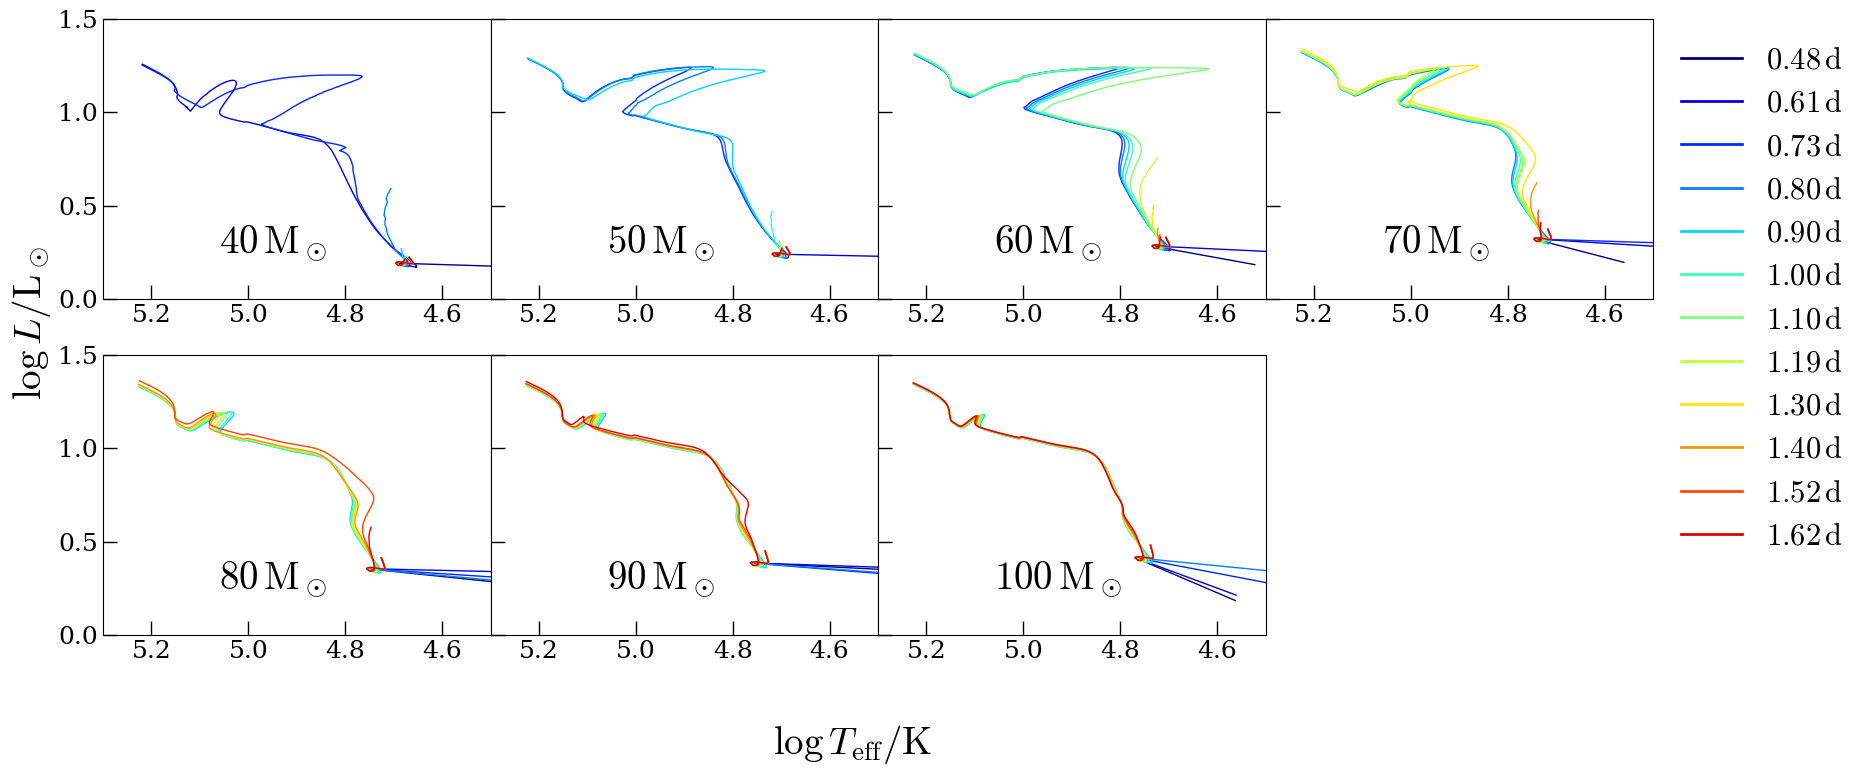

In [28]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.flatten()
fig.subplots_adjust(wspace=0)

xlim = (5.3, 4.5)
ylim = (0, 1.5)

# PLOT M=40
ax = axes[0]
models_to_plot = [0]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(0.3, 0.2, '$40\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=50
ax = axes[1]
models_to_plot = [1]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$50\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=60
ax = axes[2]
models_to_plot = [2]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$60\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=70
ax = axes[3]
models_to_plot = [3]
model_style_list = ['-']
legend = True
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$70\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=80
ax = axes[4]
models_to_plot = [4]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(0.3, 0.2, '$80\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=90
ax = axes[5]
models_to_plot = [5]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$90\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)


# PLOT M=100
ax = axes[6]
models_to_plot = [6]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$100\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# EMPTY AXIS
ax = axes[7]
ax.axis('off')

#######################################

fig.text(0.5, 0, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', va='top', ha='center')
fig.text(0.1, 0.5, '$\\log L/\\mathrm{L}_\\odot$', rotation=90, va='center', ha='right')

savefig(fig, 'hre_allp_mass_comparison')

## Core properties

In [67]:
model_dicts

array([{'20.0': {'1.19': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_HeExh_test/08_md1_m20_01zsun_04y0_03dy_HeExh/m2.0d+01_w6.1d-05'), '0.61': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_HeExh_test/08_md1_m20_01zsun_04y0_03dy_HeExh/m2.0d+01_w1.2d-04'), '1.62': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_HeExh_test/08_md1_m20_01zsun_04y0_03dy_HeExh/m2.0d+01_w4.5d-05'), '1.30': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_HeExh_test/08_md1_m20_01zsun_04y0_03dy_HeExh/m2.0d+01_w5.6d-05'), '0.73': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_HeExh_test/08_md1_m20_01zsun_04y0_03dy_HeExh/m2.0d+01_w1.0d-04'), '0.48': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_HeExh_test/08_md1_m20_01zsun_04y0_03dy_HeExh/m2.0d+01_w1.5d-04'), '0.90': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_HeExh_test/08_md1_m20_01zsun_04y0_03dy_HeExh/m2.0d+01_w8.1d-05'), '0.80': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_HeExh_test/08_md1_m20_01zsun_04y0_03dy_HeExh/m2.0d+01_w9.1d-05'), '1.52': PosixPa

In [68]:
# Select models
models_to_plot = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
model_dict_list = model_dicts[models_to_plot]
print(f'Loading {model_dict_list}')

# Collect periods
all_periods = []
for dict_ in model_dict_list:
    for k1 in dict_.keys():
        for k2 in dict_[k1].keys():
            all_periods.append(k2)
all_periods = np.unique(all_periods)
all_periods = all_periods[np.argsort([float(p) for p in all_periods])][1:]
print(all_periods)

# Get core properties
core_def_iso = 'o16'

p_plot = np.zeros((len(model_dict_list), len(all_periods), 7))
for j, p_key in enumerate(all_periods):
    print(f'Working for p={p_key}')
    p = float(p_key)    
    for i, dict_ in enumerate(model_dict_list):
        m_key = list(dict_.keys())[0]
        print(f'Working for m={m_key}')
        model_path = dict_[m_key][p_key]
        try:
            logs = mr.MesaLogDir(str(model_path/'LOGS'))
        except:
            continue
        else:
            final_h1_cntr = logs.profile_data(profile_number=logs.profile_numbers[-1]).h1[-1]
            if final_h1_cntr > 1e-7:
                print(f'Not CHE! m={m_key}, p={p_key}')
                is_che = False
                is_crit_at_zams = False
                #p_plot[i, j] = [np.nan]*5 + [is_crit_at_zams, is_che]
            else:
                is_che = True
                mass, spin, w = get_core_mass_spin_w(logs, core_def_iso)
                
                h = mr.MesaData(str(model_path/'LOGS/history.data'))
                r_prezams = h.radius[0]
                i_zams = np.searchsorted(h.surf_avg_v_rot, 0, side='right')
                
                is_crit_at_zams = False
                try:
                    r_zams = h.radius[i_zams]
                except IndexError:
                    is_crit_at_zams = True
                    r_zams = h.radius[i_zams-1]        
        finally:
            p_plot[i, j] = [mass, spin, w, r_zams, r_prezams, is_crit_at_zams, is_che]    

Loading [{'20.0': {'1.19': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_HeExh_test/08_md1_m20_01zsun_04y0_03dy_HeExh/m2.0d+01_w6.1d-05'), '0.61': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_HeExh_test/08_md1_m20_01zsun_04y0_03dy_HeExh/m2.0d+01_w1.2d-04'), '1.62': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_HeExh_test/08_md1_m20_01zsun_04y0_03dy_HeExh/m2.0d+01_w4.5d-05'), '1.30': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_HeExh_test/08_md1_m20_01zsun_04y0_03dy_HeExh/m2.0d+01_w5.6d-05'), '0.73': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_HeExh_test/08_md1_m20_01zsun_04y0_03dy_HeExh/m2.0d+01_w1.0d-04'), '0.48': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_HeExh_test/08_md1_m20_01zsun_04y0_03dy_HeExh/m2.0d+01_w1.5d-04'), '0.90': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_HeExh_test/08_md1_m20_01zsun_04y0_03dy_HeExh/m2.0d+01_w8.1d-05'), '0.80': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_HeExh_test/08_md1_m20_01zsun_04y0_03dy_HeExh/m2.0d+01_w9.1d-05'), '1.52': Posix

In [69]:
np.save('nb26_p_plot_extended.npy', p_plot)

In [70]:
mass_guide_str = [list(dict_.keys())[0] for dict_ in model_dict_list]
mass_guide_float = np.array([float(m) for m in mass_guide_str])

period_guide_str = all_periods
period_guide_float = np.array([float(p) for p in period_guide_str])

In [71]:
from scipy.interpolate import interp1d

In [72]:
from math import nan

Below we build a core mass interpolator.

In [76]:
interpolator_dict = dict()

for i, m in enumerate(mass_guide_float):
    m_key = mass_guide_str[i]
    p_arr = period_guide_float   
    y_arr = p_plot[i, :, 0] 

    mask = np.array(p_plot[i, :, 6], bool)
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    
    if len(y_arr) == 0:
        y_arr = [0]
        p_arr = [1]

    interpolator = interp1d(
        x=p_arr,
        y=y_arr,
        kind='linear',
        bounds_error=False,
        fill_value='extrapolate'
    )
    
    interpolator_dict[m_key] = interpolator     
    
pzams_mcore_interpolator_dict = interpolator_dict

/tmp/ipykernel_1657933/1652121095.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(period_guide_float[che_mask], p_plot[i,:,0][che_mask], marker='o', c=c, zorder=1)
/tmp/ipykernel_1657933/1652121095.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(period_guide_float[~che_mask], p_plot[i,:,0][~che_mask], marker='x', c=c, zorder=2)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-v

Text(0.5, 1.0, 'Data + $P$ interpolation')

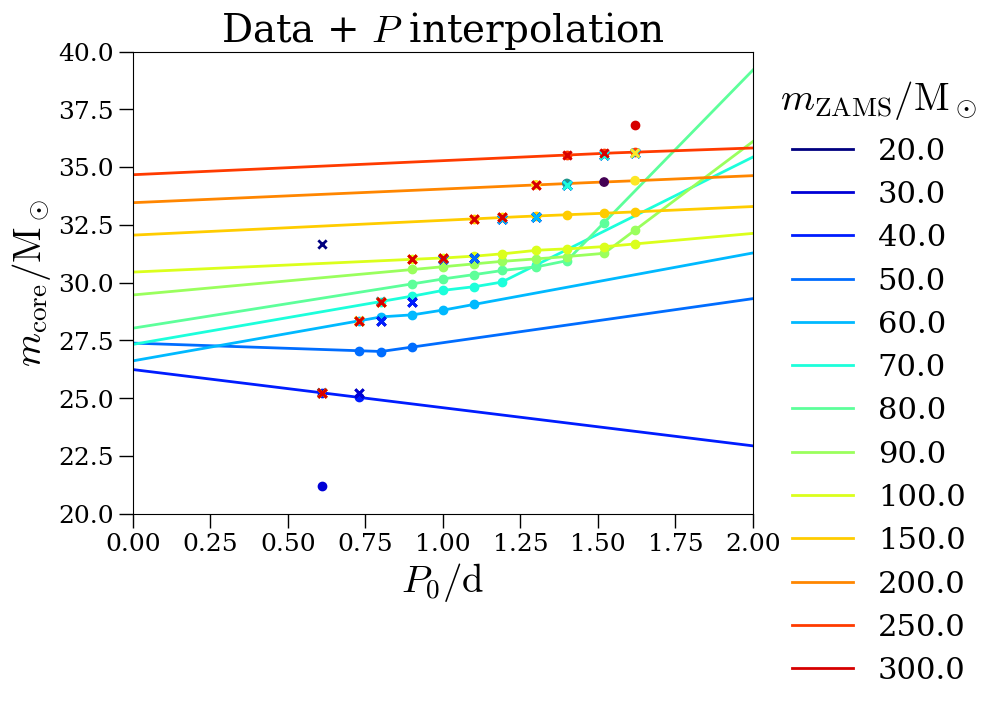

In [77]:
fig, ax = plt.subplots(figsize=(8, 6))
interpolator_dict = pzams_mcore_interpolator_dict

for i, m_key in enumerate(mass_guide_str):
    c = cm.jet(i/len(mass_guide_str))
    interpolator = interpolator_dict[m_key]
    plot_ps = np.linspace(0, 2, 1000)
    che_mask = np.array(p_plot[i,:,6], bool)
    ax.scatter(period_guide_float[che_mask], p_plot[i,:,0][che_mask], marker='o', c=c, zorder=1)
    ax.scatter(period_guide_float[~che_mask], p_plot[i,:,0][~che_mask], marker='x', c=c, zorder=2)
    ax.plot(plot_ps, interpolator(plot_ps), c=c, label=m_key, zorder=0)
    
ax.set_ylim(20, 40)
ax.set_xlim(0, 2)

ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$m_\\mathrm{core}/\\mathrm{M}_\\odot$')

ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
ax.set_title('Data + $P$ interpolation')

#savefig(fig, 'pzams_mcore_data')

Text(0.5, 1.0, '$90\\,\\mathrm{M}_\\odot$')

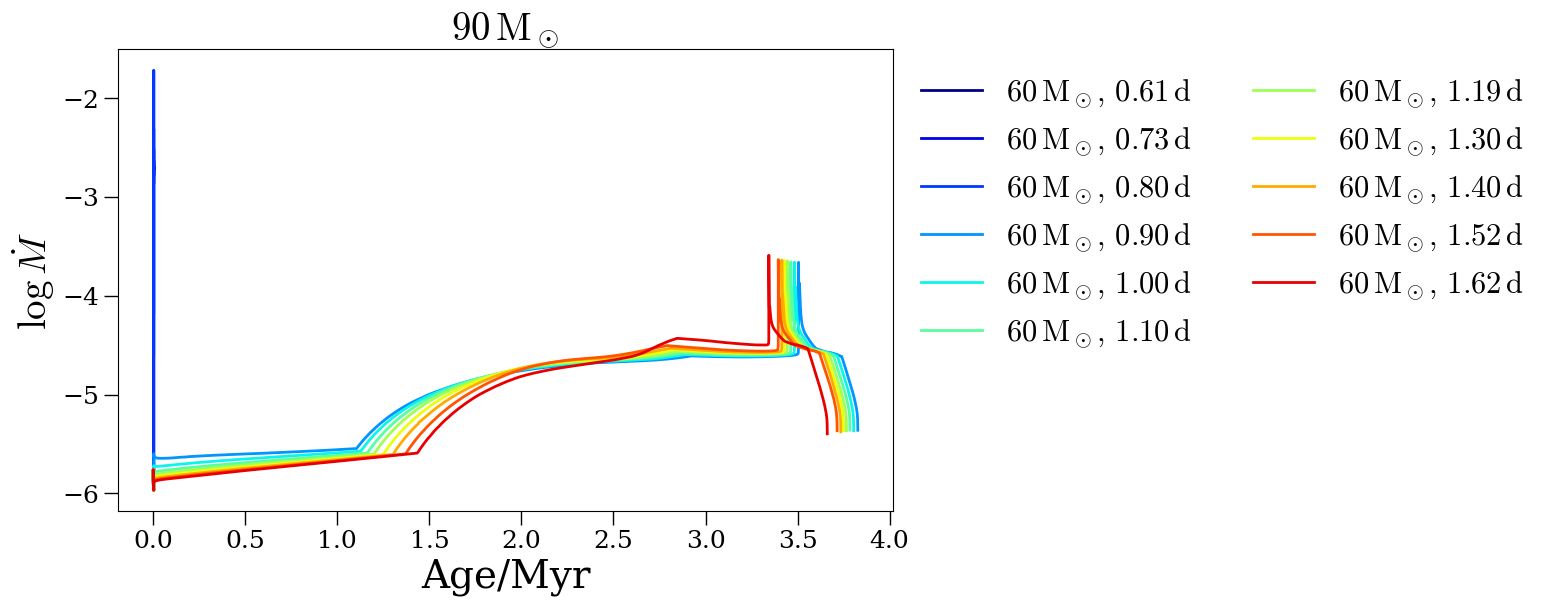

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))

dict_ = model_dicts[5]['90.0']
for i, p_key in enumerate(all_periods):
    c = cm.jet(i/len(all_periods))
    h = mr.MesaData(str(dict_[p_key]/'LOGS/history.data'))
    ax.plot(
        h.star_age/1e6, 
        h.log_abs_mdot, 
        c=c,
        label=f'$60\\,\\mathrm{{M}}_\\odot,\\,{p_key}\\,\\mathrm{{d}}$'
        )

ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\\log\\dot{M}$')
ax.set_title('$90\,\\mathrm{M}_\\odot$')

Text(0.5, 1.0, '$90\\,\\mathrm{M}_\\odot$')

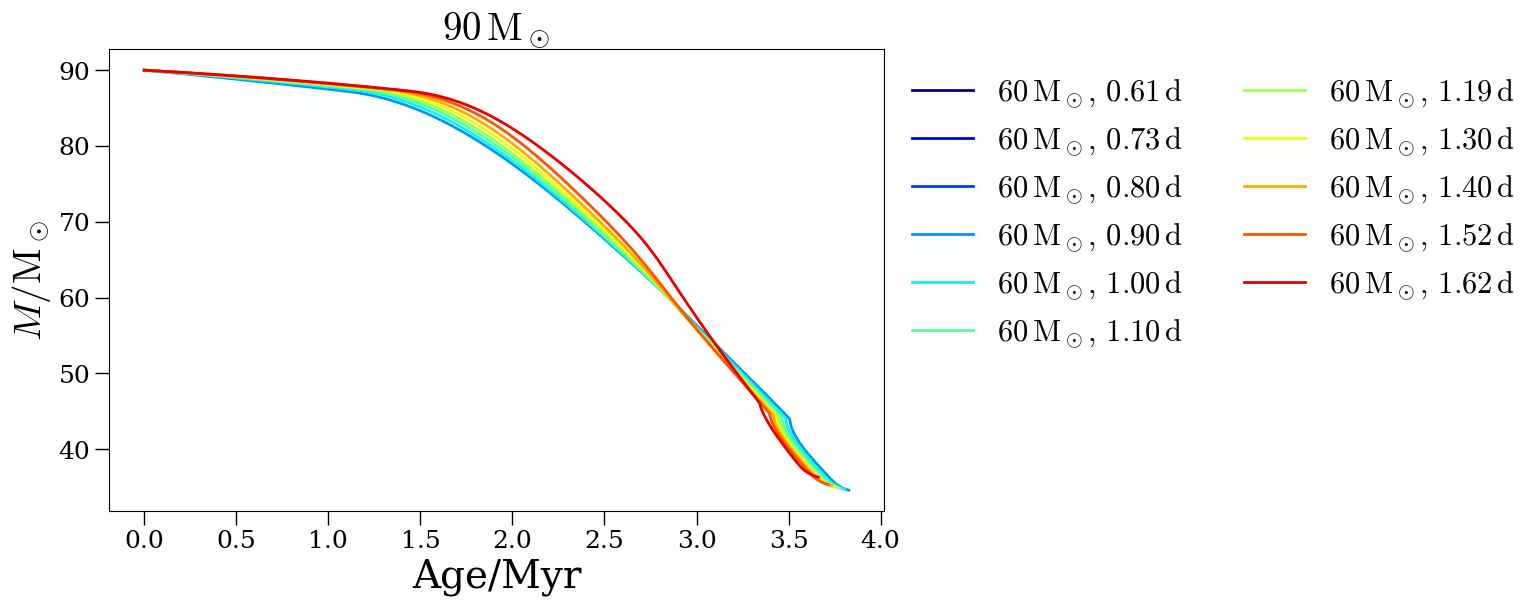

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))

dict_ = model_dicts[5]['90.0']
for i, p_key in enumerate(all_periods):
    c = cm.jet(i/len(all_periods))
    h = mr.MesaData(str(dict_[p_key]/'LOGS/history.data'))
    ax.plot(
        h.star_age/1e6, 
        h.star_mass, 
        c=c,
        label=f'$60\\,\\mathrm{{M}}_\\odot,\\,{p_key}\\,\\mathrm{{d}}$'
        )

ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
ax.set_xlabel('Age/Myr')
ax.set_ylabel('$M/\\mathrm{M}_\\odot$')
ax.set_title('$90\,\\mathrm{M}_\\odot$')

Text(0.5, 1.0, '$100\\,\\mathrm{M}_\\odot$')

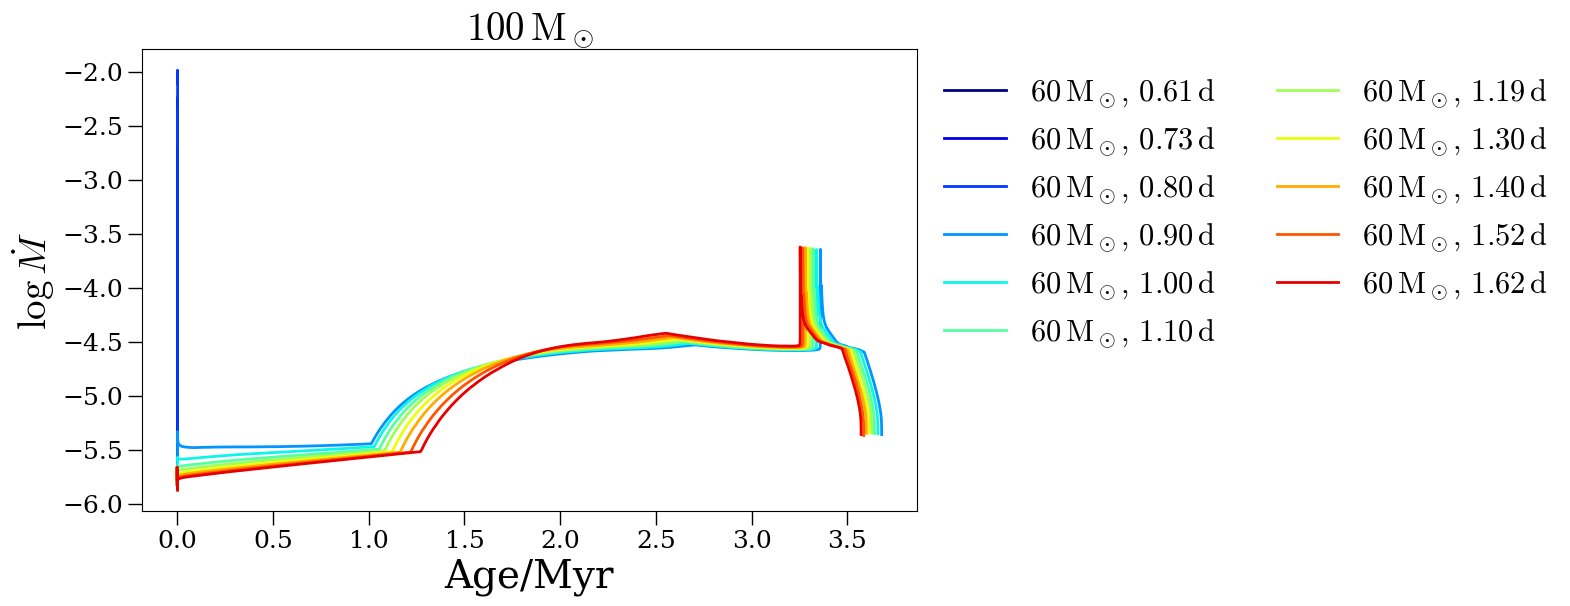

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))

dict_ = model_dicts[6]['100.0']
for i, p_key in enumerate(all_periods):
    c = cm.jet(i/len(all_periods))
    h = mr.MesaData(str(dict_[p_key]/'LOGS/history.data'))
    ax.plot(
        h.star_age/1e6, 
        h.log_abs_mdot, 
        c=c,
        label=f'$60\\,\\mathrm{{M}}_\\odot,\\,{p_key}\\,\\mathrm{{d}}$'
        )

ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\\log\\dot{M}$')
ax.set_title('$100\,\\mathrm{M}_\\odot$')

Text(0.5, 1.0, '$100\\,\\mathrm{M}_\\odot$')

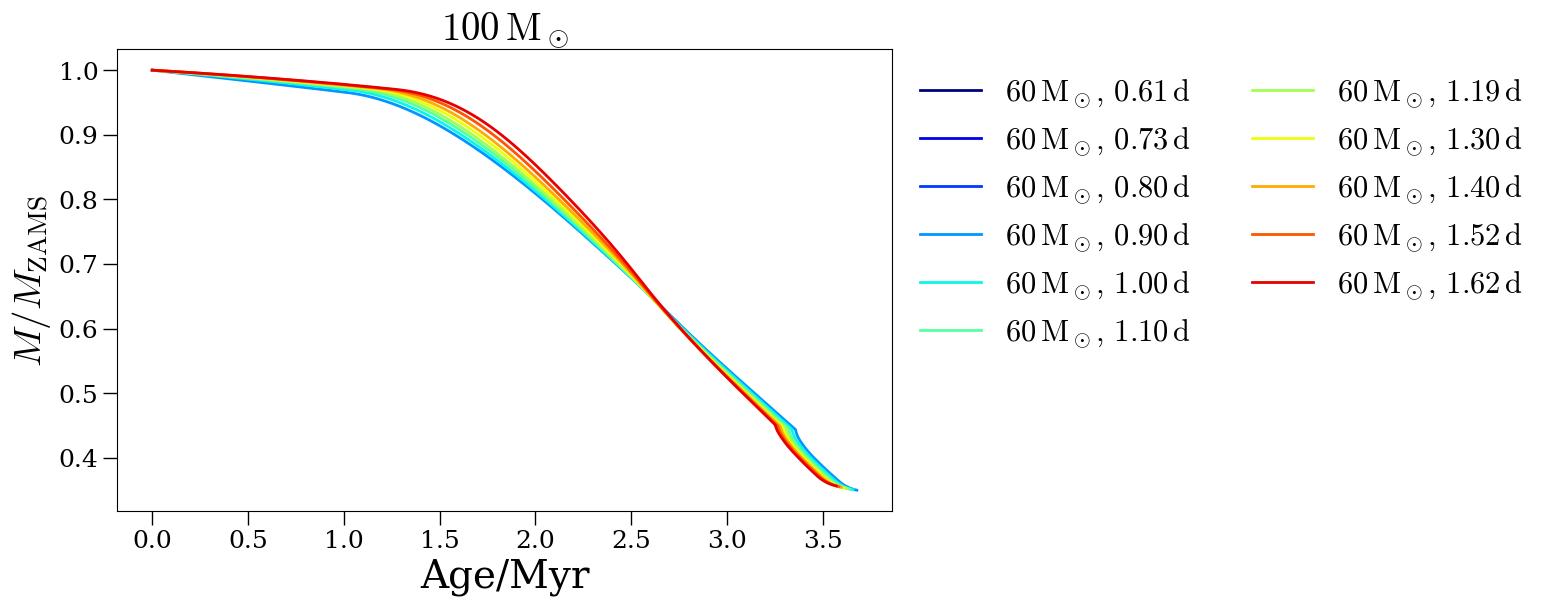

In [39]:
fig, ax = plt.subplots(figsize=(10, 6))

dict_ = model_dicts[6]['100.0']
for i, p_key in enumerate(all_periods):
    c = cm.jet(i/len(all_periods))
    h = mr.MesaData(str(dict_[p_key]/'LOGS/history.data'))
    ax.plot(
        h.star_age/1e6, 
        h.star_mass/100, 
        c=c,
        label=f'$60\\,\\mathrm{{M}}_\\odot,\\,{p_key}\\,\\mathrm{{d}}$'
        )

ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
ax.set_xlabel('Age/Myr')
ax.set_ylabel('$M/M_\\mathrm{ZAMS}$')
ax.set_title('$100\,\\mathrm{M}_\\odot$')

In [78]:
def mzams_mcore_interpolator(m_zams, p_zams):
    ip_m_cores = []
    for m_key in mass_guide_str:
        interpolator = pzams_mcore_interpolator_dict[m_key]
        ip_m_cores.append(interpolator(p_zams))
    
    interpolator = interp1d(
        x=mass_guide_float,
        y=ip_m_cores,
        kind='linear',
        bounds_error=False,
        fill_value='extrapolate'
    )
    
    m_core = interpolator(m_zams)
    
    return m_core  
    

Text(0.5, 1.0, 'Data + $P,m_\\mathrm{ZAMS}$ interpolation')

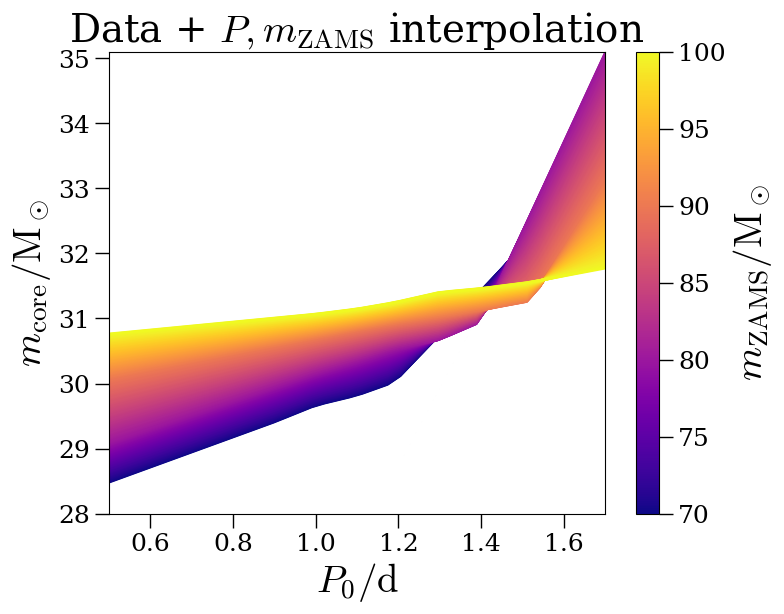

In [79]:
fig, ax = plt.subplots(figsize=(8, 6))
interpolator = mzams_mcore_interpolator
cmap = cm.plasma

test_masses = np.linspace(70, 100, 300)
test_periods = np.linspace(0.5, 2)

for i, m in enumerate(test_masses):
    c = cmap(i/len(test_masses))
    m_cores = [interpolator(m, p) for p in test_periods]
    ax.plot(test_periods, m_cores, c=c, lw=2, label=f'${m:.1f}$')
    
ax.set_ylim(28, 35.1)
ax.set_xlim(0.5, 1.7)

ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$m_\\mathrm{core}/\\mathrm{M}_\\odot$')

#ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
sm = ScalarMappable(norm=Normalize(vmin=min(test_masses), vmax=max(test_masses)), cmap=cmap)
cb = fig.colorbar(mappable=sm, ax=ax)
cb.set_label('$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')

ax.set_title('Data + $P,m_\\mathrm{ZAMS}$ interpolation')

#savefig(fig, 'pzams_mcore_ip')

Below we build a ZAMS radius interpolator.

In [82]:
interpolator_dict = dict()

for i, m in enumerate(mass_guide_float):
    m_key = mass_guide_str[i]
    p_arr = period_guide_float   
    y_arr = p_plot[i, :, 3] 

    mask = np.array(p_plot[i, :, 6], bool)
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]

    if len(y_arr) == 0:
        y_arr = [0]
        p_arr = [1]
            
    interpolator = interp1d(
        x=p_arr,
        y=y_arr,
        kind='linear',
        bounds_error=False,
        fill_value='extrapolate'
    )
    
    interpolator_dict[m_key] = interpolator     
    
pzams_rzams_interpolator_dict = interpolator_dict

/tmp/ipykernel_1657933/2157960599.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(period_guide_float[che_mask], p_plot[i,:,3][che_mask], marker='o', c=c, zorder=1)
/tmp/ipykernel_1657933/2157960599.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(period_guide_float[~che_mask], p_plot[i,:,3][~che_mask], marker='x', c=c, zorder=2)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-v

Text(0.5, 1.0, 'Data + $P$ interpolation')

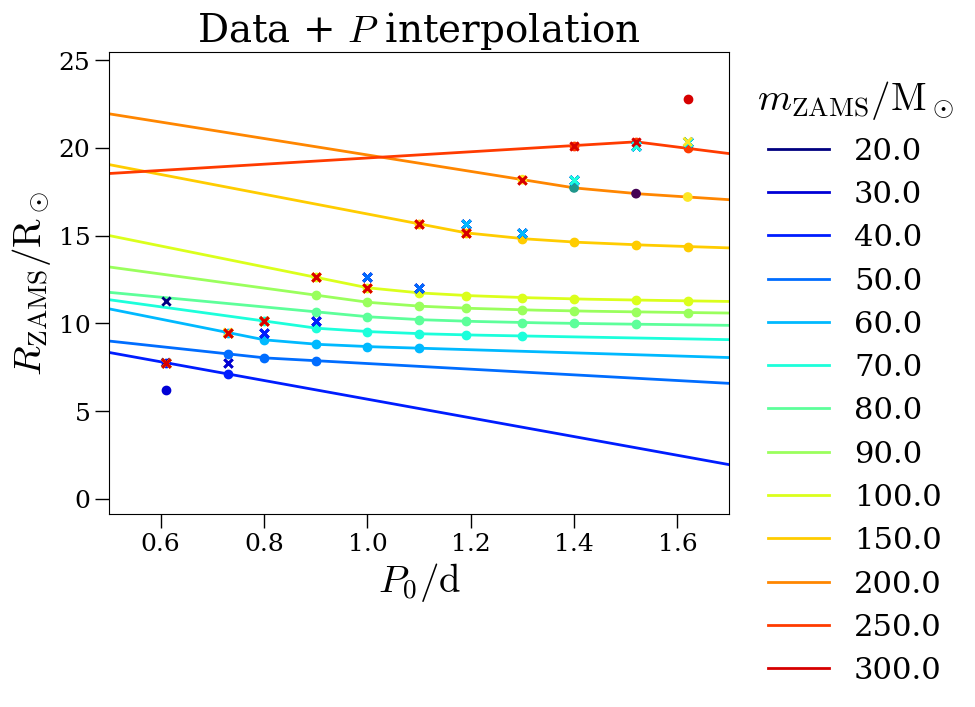

In [83]:
fig, ax = plt.subplots(figsize=(8, 6))
interpolator_dict = pzams_rzams_interpolator_dict

for i, m_key in enumerate(mass_guide_str):
    c = cm.jet(i/len(mass_guide_str))
    interpolator = interpolator_dict[m_key]
    plot_ps = np.linspace(0, 2, 1000)
    che_mask = np.array(p_plot[i,:,6], bool)
    ax.scatter(period_guide_float[che_mask], p_plot[i,:,3][che_mask], marker='o', c=c, zorder=1)
    ax.scatter(period_guide_float[~che_mask], p_plot[i,:,3][~che_mask], marker='x', c=c, zorder=2)
    ax.plot(plot_ps, interpolator(plot_ps), c=c, label=m_key, zorder=0)
    
#ax.set_ylim(20, 40)
ax.set_xlim(0.5, 1.7)

ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$R_\\mathrm{ZAMS}/\\mathrm{R}_\\odot$')

ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
ax.set_title('Data + $P$ interpolation')

#savefig(fig, 'pzams_rzams_data')

In [84]:
def mzams_rzams_interpolator(m_zams, p_zams):
    ip_m_cores = []
    for m_key in mass_guide_str:
        interpolator = pzams_rzams_interpolator_dict[m_key]
        ip_m_cores.append(interpolator(p_zams))
    
    interpolator = interp1d(
        x=mass_guide_float,
        y=ip_m_cores,
        kind='linear',
        bounds_error=False,
        fill_value='extrapolate'
    )
    
    m_core = interpolator(m_zams)
    
    return m_core      

Text(0.5, 1.0, 'Data + $P,m_\\mathrm{ZAMS}$ interpolation')

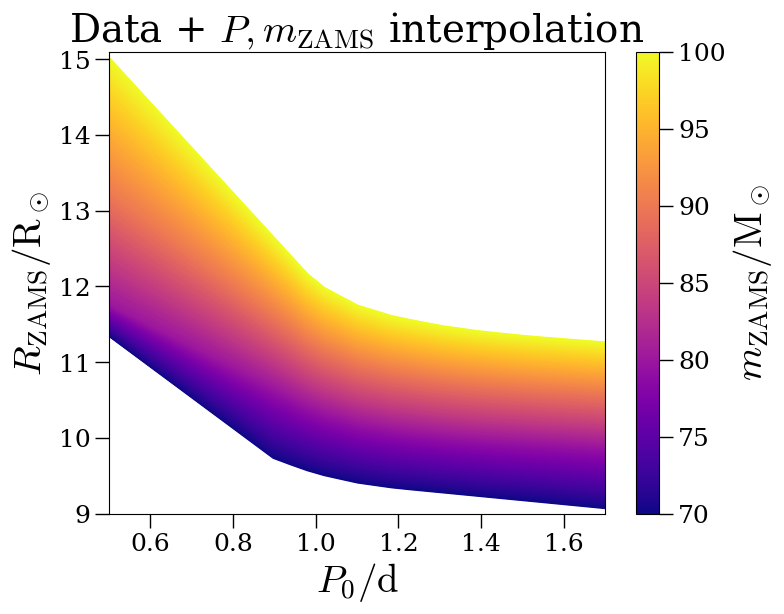

In [85]:
fig, ax = plt.subplots(figsize=(8, 6))
interpolator = mzams_rzams_interpolator
cmap = cm.plasma

test_masses = np.linspace(70, 100, 300)
test_periods = np.linspace(0, 2)

for i, m in enumerate(test_masses):
    c = cmap(i/len(test_masses))
    m_cores = [interpolator(m, p) for p in test_periods]
    ax.plot(test_periods, m_cores, c=c, lw=2, label=f'${m:.1f}$')
    
ax.set_ylim(9, 15.1)
ax.set_xlim(0.5, 1.7)

ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$R_\\mathrm{ZAMS}/\\mathrm{R}_\\odot$')

#ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
sm = ScalarMappable(norm=Normalize(vmin=min(test_masses), vmax=max(test_masses)), cmap=cmap)
cb = fig.colorbar(mappable=sm, ax=ax)
cb.set_label('$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')

ax.set_title('Data + $P,m_\\mathrm{ZAMS}$ interpolation')

#savefig(fig, 'pzams_rzams_ip')

Below we build a pre-ZAMS radius interpolator.

In [86]:
interpolator_dict = dict()

for i, m in enumerate(mass_guide_float):
    m_key = mass_guide_str[i]
    p_arr = period_guide_float   
    y_arr = p_plot[i, :, 4] 

    mask = np.array(p_plot[i, :, 6], bool)
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    
    if len(y_arr) == 0:
        y_arr = [0]
        p_arr = [1]

    interpolator = interp1d(
        x=p_arr,
        y=y_arr,
        kind='linear',
        bounds_error=False,
        fill_value='extrapolate'
    )
    
    interpolator_dict[m_key] = interpolator     
    
pzams_rprezams_interpolator_dict = interpolator_dict

/tmp/ipykernel_1657933/2769665211.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(period_guide_float[che_mask], p_plot[i,:,4][che_mask], marker='o', c=c, zorder=1)
/tmp/ipykernel_1657933/2769665211.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(period_guide_float[~che_mask], p_plot[i,:,4][~che_mask], marker='x', c=c, zorder=2)


Text(0.5, 1.0, 'Data + $P$ interpolation')

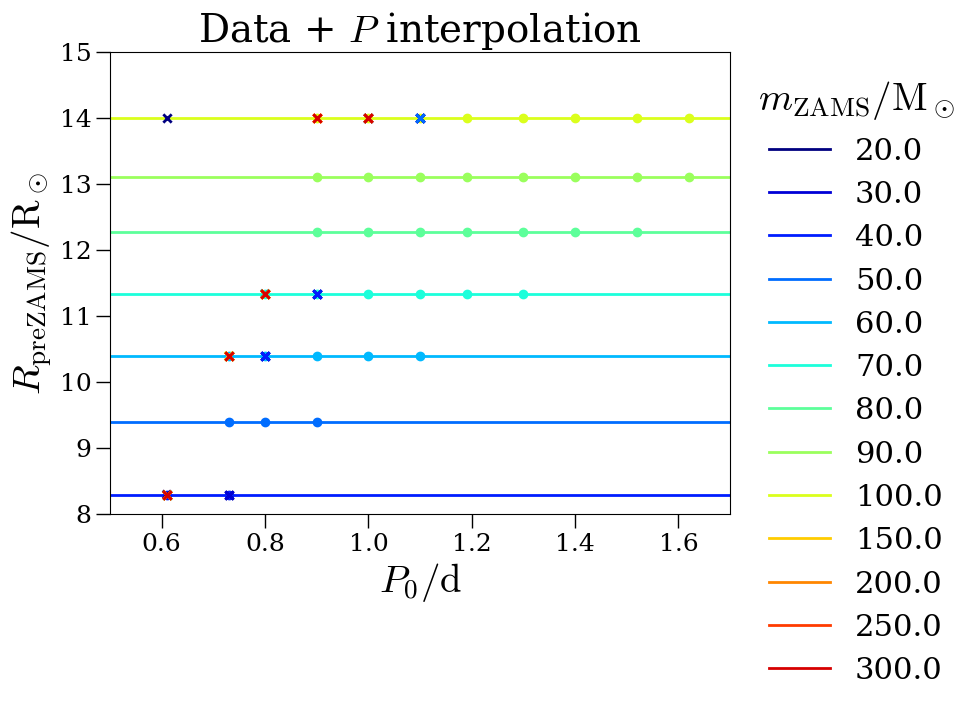

In [87]:
fig, ax = plt.subplots(figsize=(8, 6))
interpolator_dict = pzams_rprezams_interpolator_dict

for i, m_key in enumerate(mass_guide_str):
    c = cm.jet(i/len(mass_guide_str))
    interpolator = interpolator_dict[m_key]
    plot_ps = np.linspace(0, 2, 1000)
    che_mask = np.array(p_plot[i,:,6], bool)
    ax.scatter(period_guide_float[che_mask], p_plot[i,:,4][che_mask], marker='o', c=c, zorder=1)
    ax.scatter(period_guide_float[~che_mask], p_plot[i,:,4][~che_mask], marker='x', c=c, zorder=2)
    ax.plot(plot_ps, interpolator(plot_ps), c=c, label=m_key, zorder=0)
    
ax.set_ylim(8, 15)
ax.set_xlim(0.5, 1.7)

ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$R_\\mathrm{preZAMS}/\\mathrm{R}_\\odot$')

ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
ax.set_title('Data + $P$ interpolation')

#savefig(fig, 'pzams_rprezams_data')

In [88]:
def mzams_rprezams_interpolator(m_zams, p_zams):
    ip_m_cores = []
    for m_key in mass_guide_str:
        interpolator = pzams_rprezams_interpolator_dict[m_key]
        ip_m_cores.append(interpolator(p_zams))
    
    interpolator = interp1d(
        x=mass_guide_float,
        y=ip_m_cores,
        kind='linear',
        bounds_error=False,
        fill_value='extrapolate'
    )
    
    rprezams = interpolator(m_zams)
    
    return rprezams

Text(0.5, 1.0, 'Data + $P,m_\\mathrm{ZAMS}$ interpolation')

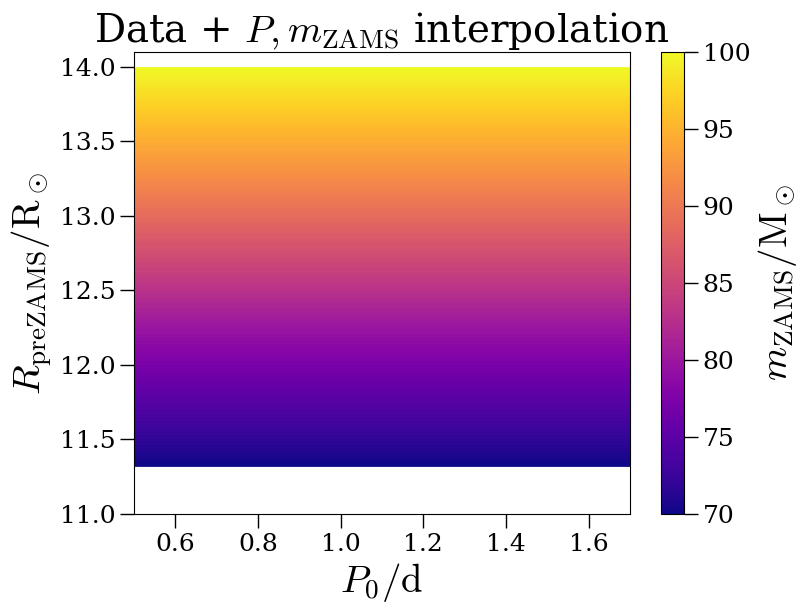

In [89]:
fig, ax = plt.subplots(figsize=(8, 6))
interpolator = mzams_rprezams_interpolator
cmap = cm.plasma

test_masses = np.linspace(70, 100, 300)
test_periods = np.linspace(0, 2)

for i, m in enumerate(test_masses):
    c = cmap(i/len(test_masses))
    m_cores = [interpolator(m, p) for p in test_periods]
    ax.plot(test_periods, m_cores, c=c, lw=2, label=f'${m:.1f}$')
    
ax.set_ylim(11, 14.1)
ax.set_xlim(0.5, 1.7)

ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$R_\\mathrm{preZAMS}/\\mathrm{R}_\\odot$')

#ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
sm = ScalarMappable(norm=Normalize(vmin=min(test_masses), vmax=max(test_masses)), cmap=cmap)
cb = fig.colorbar(mappable=sm, ax=ax)
cb.set_label('$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')

ax.set_title('Data + $P,m_\\mathrm{ZAMS}$ interpolation')

#savefig(fig, 'pzams_rprezams_ip')

Comparing pre-ZAMS and ZAMS radii.

Text(0.5, 1.0, 'Data + $P,m_\\mathrm{ZAMS}$ interpolation')

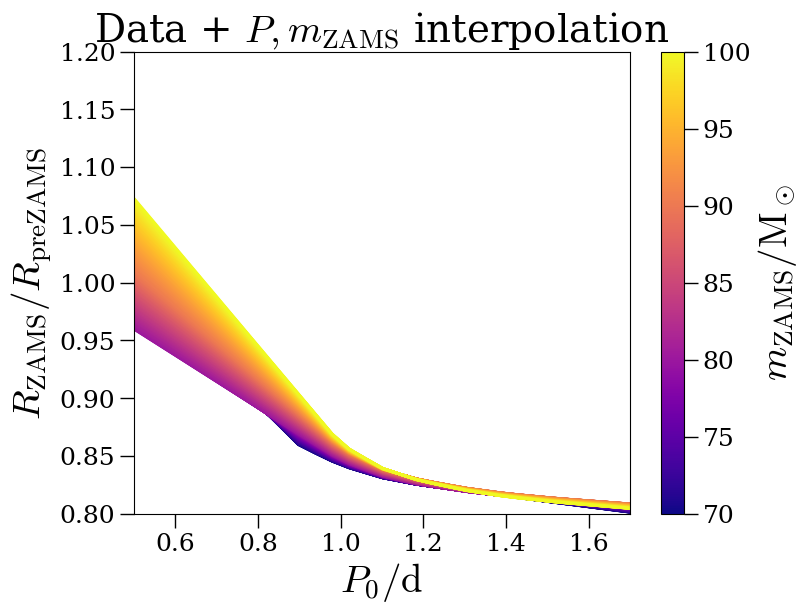

In [90]:
fig, ax = plt.subplots(figsize=(8, 6))
interpolator1 = mzams_rzams_interpolator
interpolator2 = mzams_rprezams_interpolator
cmap = cm.plasma

test_masses = np.linspace(70, 100, 300)
test_periods = np.linspace(0, 2)

for i, m in enumerate(test_masses):
    c = cmap(i/len(test_masses))
    m_cores = [interpolator1(m, p)/interpolator2(m, p) for p in test_periods]
    ax.plot(test_periods, m_cores, c=c, lw=2, label=f'${m:.1f}$')
    
ax.set_ylim(0.8, 1.2)
ax.set_xlim(0.5, 1.7)

ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$R_\\mathrm{ZAMS}/R_\\mathrm{preZAMS}$')

#ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
sm = ScalarMappable(norm=Normalize(vmin=min(test_masses), vmax=max(test_masses)), cmap=cmap)
cb = fig.colorbar(mappable=sm, ax=ax)
cb.set_label('$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')

ax.set_title('Data + $P,m_\\mathrm{ZAMS}$ interpolation')

#savefig(fig, 'zams_prezams_radii_ip')

/tmp/ipykernel_1657933/2913637785.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(period_guide_float[che_mask], p_plot[i,:,3][che_mask]/p_plot[i,:,4][che_mask], marker='o', c=c, zorder=1)
/tmp/ipykernel_1657933/2913637785.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(period_guide_float[~che_mask], p_plot[i,:,3][~che_mask]/p_plot[i,:,4][~che_mask], marker='x', c=c, zorder=2)


Text(0.5, 1.0, 'Data + $P$ interpolation')

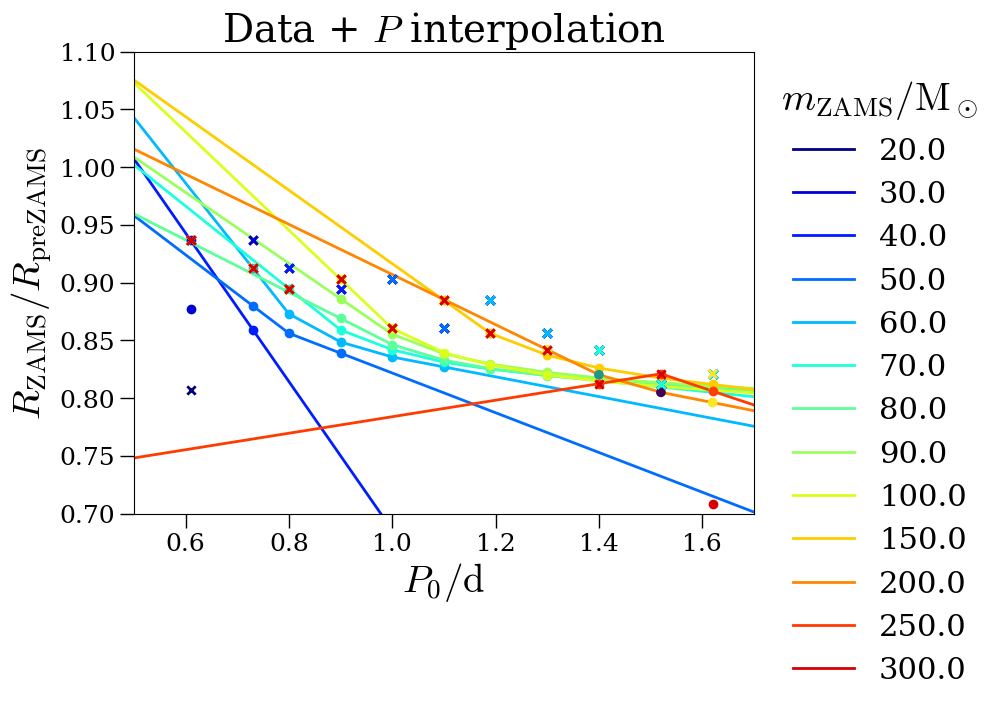

In [91]:
fig, ax = plt.subplots(figsize=(8, 6))

for i, m_key in enumerate(mass_guide_str):
    c = cm.jet(i/len(mass_guide_str))
    interpolator1 = pzams_rprezams_interpolator_dict[m_key]
    interpolator2 = pzams_rzams_interpolator_dict[m_key]
    plot_ps = np.linspace(0, 2, 1000)
    che_mask = np.array(p_plot[i,:,6], bool)
    ax.scatter(period_guide_float[che_mask], p_plot[i,:,3][che_mask]/p_plot[i,:,4][che_mask], marker='o', c=c, zorder=1)
    ax.scatter(period_guide_float[~che_mask], p_plot[i,:,3][~che_mask]/p_plot[i,:,4][~che_mask], marker='x', c=c, zorder=2)
    ax.plot(plot_ps, interpolator2(plot_ps)/interpolator1(plot_ps), c=c, label=m_key, zorder=0)
    
ax.set_ylim(0.7, 1.1)
ax.set_xlim(0.5, 1.7)

ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$R_\\mathrm{ZAMS}/R_\\mathrm{preZAMS}$')

ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
ax.set_title('Data + $P$ interpolation')

#savefig(fig, 'zams_prezams_radii_data')

We now want to check for overflow.

In [92]:
def is_of(r, m, p, q=1, kind='RL'):
    a = a_from_p(p, m, q)
    if kind == 'merger':
        of_a = a.to(u.Rsun).value
    elif kind == 'RL':
        of_a = eggleton_rl1_radius(a, q).to(u.Rsun).value
    elif kind == 'L2':
        of_a = marchant_l2_radius(a, q).to(u.Rsun).value
    else:
        raise ValueError(f'kind {kind} not recognized')
    if of_a <= r:
        isof = True
    else:
        isof = False

    return isof

In [93]:
test_masses = np.linspace(70, 100, 300)
test_periods = np.linspace(0, 2)[::-1]

of_kind = 'RL'
of_locations = np.zeros((len(test_masses), 2))
for i, m in enumerate(test_masses):
    test_of = [is_of(mzams_rzams_interpolator(m, p), m, p, q=1, kind=of_kind) for p in test_periods]
    of_i = np.where(test_of)[0][0]
    of_p = test_periods[of_i]
    of_m_core = mzams_mcore_interpolator(m, of_p)
    of_locations[i] = [of_p, of_m_core]
    
zams_rlof_locs = of_locations

In [94]:
test_masses = np.linspace(70, 100, 300)
test_periods = np.linspace(0, 2)[::-1]

of_kind = 'L2'
of_locations = np.zeros((len(test_masses), 2))
for i, m in enumerate(test_masses):
    test_of = [is_of(mzams_rzams_interpolator(m, p), m, p, q=1, kind=of_kind) for p in test_periods]
    of_i = np.where(test_of)[0][0]
    of_p = test_periods[of_i]
    of_m_core = mzams_mcore_interpolator(m, of_p)
    of_locations[i] = [of_p, of_m_core]
    
zams_l2of_locs = of_locations

In [95]:
test_masses = np.linspace(70, 100, 300)
test_periods = np.linspace(0, 2)[::-1]

of_kind = 'merger'
of_locations = np.zeros((len(test_masses), 2))
for i, m in enumerate(test_masses):
    test_of = [is_of(mzams_rzams_interpolator(m, p), m, p, q=1, kind=of_kind) for p in test_periods]
    of_i = np.where(test_of)[0][0]
    of_p = test_periods[of_i]
    of_m_core = mzams_mcore_interpolator(m, of_p)
    of_locations[i] = [of_p, of_m_core]
    
zams_merger_locs = of_locations

In [96]:
test_masses = np.linspace(70, 100, 300)
test_periods = np.linspace(0, 2)[::-1]

of_kind = 'RL'
of_locations = np.zeros((len(test_masses), 2))
for i, m in enumerate(test_masses):
    test_of = [is_of(mzams_rprezams_interpolator(m, p), m, p, q=1, kind=of_kind) for p in test_periods]
    of_i = np.where(test_of)[0][0]
    of_p = test_periods[of_i]
    of_m_core = mzams_mcore_interpolator(m, of_p)
    of_locations[i] = [of_p, of_m_core]
    
prezams_rlof_locs = of_locations

In [97]:
test_masses = np.linspace(70, 100, 300)
test_periods = np.linspace(0, 2)[::-1]

of_kind = 'L2'
of_locations = np.zeros((len(test_masses), 2))
for i, m in enumerate(test_masses):
    test_of = [is_of(mzams_rprezams_interpolator(m, p), m, p, q=1, kind=of_kind) for p in test_periods]
    of_i = np.where(test_of)[0][0]
    of_p = test_periods[of_i]
    of_m_core = mzams_mcore_interpolator(m, of_p)
    of_locations[i] = [of_p, of_m_core]
    
prezams_l2of_locs = of_locations

In [98]:
test_masses = np.linspace(70, 100, 300)
test_periods = np.linspace(0, 2)[::-1]

of_kind = 'merger'
of_locations = np.zeros((len(test_masses), 2))
for i, m in enumerate(test_masses):
    test_of = [is_of(mzams_rprezams_interpolator(m, p), m, p, q=1, kind=of_kind) for p in test_periods]
    of_i = np.where(test_of)[0][0]
    of_p = test_periods[of_i]
    of_m_core = mzams_mcore_interpolator(m, of_p)
    of_locations[i] = [of_p, of_m_core]
    
prezams_merger_locs = of_locations

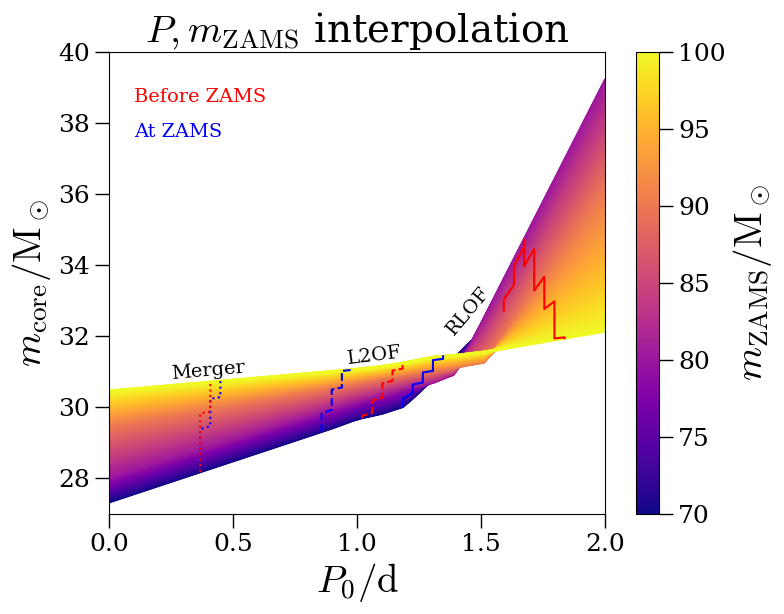

In [99]:
fig, ax = plt.subplots(figsize=(8, 6))
interpolator = mzams_mcore_interpolator
cmap = cm.plasma

for i, m in enumerate(test_masses):
    c = cmap(i/len(test_masses))
    m_cores = [interpolator(m, p) for p in test_periods]
    ax.plot(test_periods, m_cores, c=c, lw=2, label=f'${m:.1f}$')
    
ax.plot(zams_rlof_locs[:, 0], zams_rlof_locs[:, 1], 'b-', lw=1.5)
ax.plot(zams_l2of_locs[:, 0], zams_l2of_locs[:, 1], 'b--', lw=1.5)
ax.plot(zams_merger_locs[:, 0], zams_merger_locs[:, 1], 'b:', lw=1.5)

ax.plot(prezams_rlof_locs[:, 0], prezams_rlof_locs[:, 1], 'r-', lw=1.5)
ax.plot(prezams_l2of_locs[:, 0], prezams_l2of_locs[:, 1], 'r--', lw=1.5)
ax.plot(prezams_merger_locs[:, 0], prezams_merger_locs[:, 1], 'r:', lw=1.5)

ax.text(0.4, 30.7, 'Merger', rotation=5, ha='center', va='bottom', fontsize=14)
ax.text(1.07, 31.1, 'L2OF', rotation=7, ha='center', va='bottom', fontsize=14)
ax.text(1.45, 32.7, 'RLOF', rotation=50, ha='center', va='center', fontsize=14)

ax.text(0.1, 39, 'Before ZAMS', ha='left', va='top', c='r', fontsize=14)
ax.text(0.1, 38, 'At ZAMS', ha='left', va='top', c='b', fontsize=14)

ax.set_ylim(27, 40)
ax.set_xlim(0, 2)

ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$m_\\mathrm{core}/\\mathrm{M}_\\odot$')

#ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
sm = ScalarMappable(norm=Normalize(vmin=min(test_masses), vmax=max(test_masses)), cmap=cmap)
cb = fig.colorbar(mappable=sm, ax=ax)
cb.set_label('$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')

ax.set_title('$P,m_\\mathrm{ZAMS}$ interpolation')

savefig(fig, 'partial_che_window_extended')

### Extended P0 x mcore plot

In [105]:
test_masses = np.linspace(20, 300, 300)
test_periods = np.linspace(0, 2)[::-1]

of_kind = 'RL'
of_locations = np.zeros((len(test_masses), 2))
for i, m in enumerate(test_masses):
    try:
        of_i = np.where(test_of)[0][0]
    except:
        pass
    else:
        of_p = test_periods[of_i]
        of_m_core = mzams_mcore_interpolator(m, of_p)
        of_locations[i] = [of_p, of_m_core]
    
zams_rlof_locs = of_locations

#

of_kind = 'L2'
of_locations = np.zeros((len(test_masses), 2))
for i, m in enumerate(test_masses):
    test_of = [is_of(mzams_rzams_interpolator(m, p), m, p, q=1, kind=of_kind) for p in test_periods]
    try:
        of_i = np.where(test_of)[0][0]
    except:
        pass
    else:
        of_p = test_periods[of_i]
        of_m_core = mzams_mcore_interpolator(m, of_p)
        of_locations[i] = [of_p, of_m_core]
        
zams_l2of_locs = of_locations

#

of_kind = 'merger'
of_locations = np.zeros((len(test_masses), 2))
for i, m in enumerate(test_masses):
    test_of = [is_of(mzams_rzams_interpolator(m, p), m, p, q=1, kind=of_kind) for p in test_periods]
    try:
        of_i = np.where(test_of)[0][0]
    except:
        pass
    else:
        of_p = test_periods[of_i]
        of_m_core = mzams_mcore_interpolator(m, of_p)
        of_locations[i] = [of_p, of_m_core]
    
zams_merger_locs = of_locations

#

of_kind = 'RL'
of_locations = np.zeros((len(test_masses), 2))
for i, m in enumerate(test_masses):
    test_of = [is_of(mzams_rprezams_interpolator(m, p), m, p, q=1, kind=of_kind) for p in test_periods]
    try:
        of_i = np.where(test_of)[0][0]
    except:
        pass
    else:
        of_p = test_periods[of_i]
        of_m_core = mzams_mcore_interpolator(m, of_p)
        of_locations[i] = [of_p, of_m_core]
    
prezams_rlof_locs = of_locations

#

of_kind = 'L2'
of_locations = np.zeros((len(test_masses), 2))
for i, m in enumerate(test_masses):
    test_of = [is_of(mzams_rprezams_interpolator(m, p), m, p, q=1, kind=of_kind) for p in test_periods]
    try:
        of_i = np.where(test_of)[0][0]
    except:
        pass
    else:
        of_p = test_periods[of_i]
        of_m_core = mzams_mcore_interpolator(m, of_p)
        of_locations[i] = [of_p, of_m_core]
        
prezams_l2of_locs = of_locations

#

of_kind = 'merger'
of_locations = np.zeros((len(test_masses), 2))
for i, m in enumerate(test_masses):
    test_of = [is_of(mzams_rprezams_interpolator(m, p), m, p, q=1, kind=of_kind) for p in test_periods]
    try:
        of_i = np.where(test_of)[0][0]
    except:
        pass
    else:
        of_p = test_periods[of_i]
        of_m_core = mzams_mcore_interpolator(m, of_p)
        of_locations[i] = [of_p, of_m_core]
    
prezams_merger_locs = of_locations

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


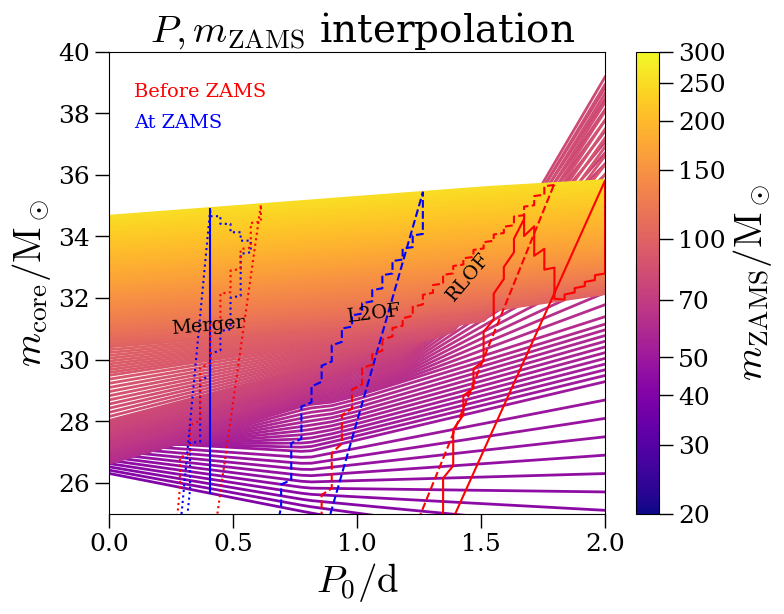

In [112]:
fig, ax = plt.subplots(figsize=(8, 6))
interpolator = mzams_mcore_interpolator
cmap = cm.plasma

for i, m in enumerate(test_masses):
    c = cmap((np.log10(m)-np.log10(20))/(np.log10(300)-np.log10(20)))
    m_cores = [interpolator(m, p) for p in test_periods]
    ax.plot(test_periods, m_cores, c=c, lw=2, label=f'${m:.1f}$')
    
ax.plot(zams_rlof_locs[:, 0], zams_rlof_locs[:, 1], 'b-', lw=1.5)
ax.plot(zams_l2of_locs[:, 0], zams_l2of_locs[:, 1], 'b--', lw=1.5)
ax.plot(zams_merger_locs[:, 0], zams_merger_locs[:, 1], 'b:', lw=1.5)

ax.plot(prezams_rlof_locs[:, 0], prezams_rlof_locs[:, 1], 'r-', lw=1.5)
ax.plot(prezams_l2of_locs[:, 0], prezams_l2of_locs[:, 1], 'r--', lw=1.5)
ax.plot(prezams_merger_locs[:, 0], prezams_merger_locs[:, 1], 'r:', lw=1.5)

ax.text(0.4, 30.7, 'Merger', rotation=5, ha='center', va='bottom', fontsize=14)
ax.text(1.07, 31.1, 'L2OF', rotation=7, ha='center', va='bottom', fontsize=14)
ax.text(1.45, 32.7, 'RLOF', rotation=50, ha='center', va='center', fontsize=14)

ax.text(0.1, 39, 'Before ZAMS', ha='left', va='top', c='r', fontsize=14)
ax.text(0.1, 38, 'At ZAMS', ha='left', va='top', c='b', fontsize=14)

ax.set_ylim(25, 40)
ax.set_xlim(0, 2)

ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$m_\\mathrm{core}/\\mathrm{M}_\\odot$')

#ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
sm = ScalarMappable(norm=Normalize(vmin=min(np.log10(test_masses)), vmax=max(np.log10(test_masses))), cmap=cmap)
cb = fig.colorbar(mappable=sm, ax=ax)
cb.set_label('$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
cb.set_ticks(np.log10([20, 30, 40, 50, 70, 100, 150, 200, 250, 300]))
cb.set_ticklabels([20, 30, 40, 50, 70, 100, 150, 200, 250, 300])

ax.set_title(' $P,m_\\mathrm{ZAMS}$ interpolation')

savefig(fig, 'full_che_window_extended')

# Mixing timescale

# Core mass distribution

In [113]:
res = int(1e6)
min_m = 40
max_m = 100
min_p = 0.1
max_p = 2

sample_masses = np.linspace(40, 100, res)
sample_probs = sample_masses**-2.3/np.sum(sample_masses**-2.3)
sample_masses = np.random.choice(sample_masses, p=sample_probs, size=int(res/100))

sample_periods = np.linspace(np.log10(min_p), np.log10(max_p), res)
sample_probs = np.ones(res)/res
sample_periods = 10.**np.random.choice(sample_periods, p=sample_probs, size=int(res/100))

sample_prezams_rs = np.array([mzams_rprezams_interpolator(m, p) for m, p in zip(sample_masses, sample_periods)])
sample_zams_rs = np.array([mzams_rzams_interpolator(m, p) for m, p in zip(sample_masses, sample_periods)])

sample_mcores = np.zeros(int(res/100))

sample_ = np.array([sample_masses, sample_periods, sample_prezams_rs, sample_zams_rs, sample_mcores]).T

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


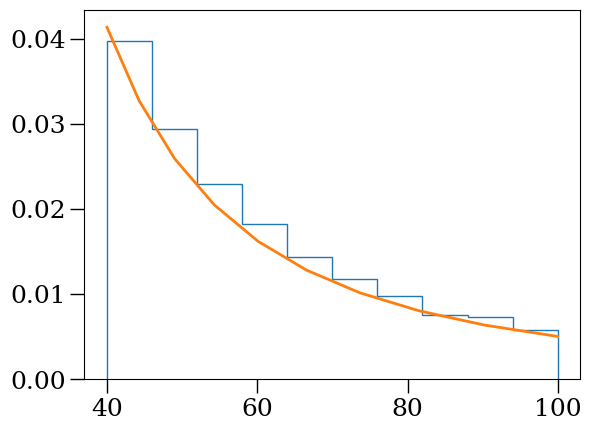

In [114]:
plt.stairs(*np.histogram(sample_masses, density=True))
plt.plot(np.logspace(np.log10(40), 2, 10), 200*np.logspace(np.log10(40), 2, 10)**-2.3)

(array([ 990.,  921., 1030., 1015., 1042.,  971.,  998., 1028.,  997.,
        1008.]),
 array([-0.99994666, -0.86985224, -0.73975783, -0.60966342, -0.47956901,
        -0.34947459, -0.21938018, -0.08928577,  0.04080864,  0.17090306,
         0.30099747]),
 <BarContainer object of 10 artists>)

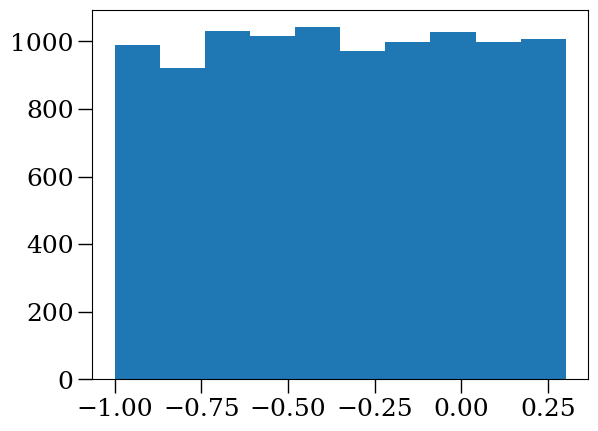

In [115]:
plt.hist(np.log10(sample_periods))

In [116]:
def set_mcores(sample, of_kind='none', of_when='zams'):
    for i, star in enumerate(sample):
        if of_when == 'zams':
            r = star[3]
        elif of_when == 'prezams':
            r = star[2]
        else:
            raise ValueError(f'Value {of_when} not valid for arg of_when')
        
        if of_kind == 'none':
            mcore = mzams_mcore_interpolator(star[0], star[1])
        else:
            try:
                isof = is_of(r=r, m=star[0], p=star[1], q=1, kind=of_kind)            
            except ValueError:
                raise ValueError(f'Value {of_kind} not valid for arg of_kind')
            else:
                if isof:
                    mcore = nan
                else:
                    mcore = mzams_mcore_interpolator(star[0], star[1])
                
        sample[i, 4] = mcore
    return sample

In [117]:
full_sample = set_mcores(sample_, of_kind='none').copy()

zams_rlof_sample = set_mcores(sample_, of_kind='RL', of_when='zams').copy()
zams_l2of_sample = set_mcores(sample_, of_kind='L2', of_when='zams').copy()
zams_merger_sample = set_mcores(sample_, of_kind='merger', of_when='zams').copy()

prezams_rlof_sample = set_mcores(sample_, of_kind='RL', of_when='prezams').copy()
prezams_l2of_sample = set_mcores(sample_, of_kind='L2', of_when='prezams').copy()
prezams_merger_sample = set_mcores(sample_, of_kind='merger', of_when='prezams').copy()

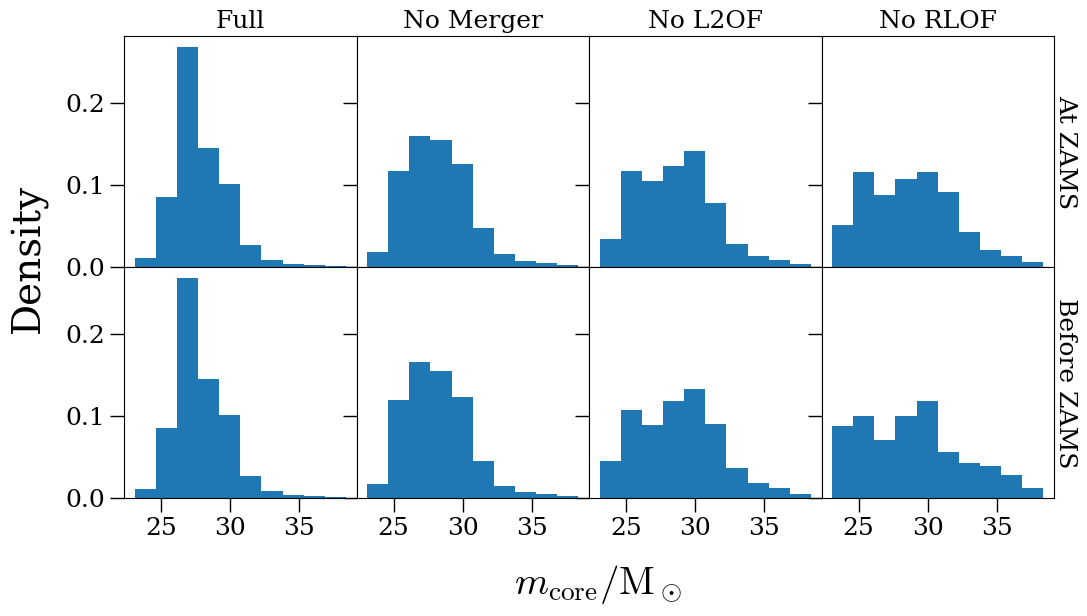

In [118]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)

# AT ZAMS ROW
# Full
axes[0, 0].hist(full_sample[:, 4], density=True)
axes[0, 0].set_title('Full', fontsize=18)

# No Merger
axes[0, 1].hist(zams_merger_sample[:, 4], density=True)
axes[0, 1].set_title('No Merger', fontsize=18)

# No L2OF
axes[0, 2].hist(zams_l2of_sample[:, 4], density=True)
axes[0, 2].set_title('No L2OF', fontsize=18)

# No RLOF
axes[0, 3].hist(zams_rlof_sample[:, 4], density=True)
axes[0, 3].text(1, 0.5, 'At ZAMS', rotation=-90, ha='left', va='center', transform=axes[0, 3].transAxes, fontsize=18)
axes[0, 3].set_title('No RLOF', fontsize=18)


# BEFORE ZAMS ROW
# Full
axes[1, 0].hist(full_sample[:, 4], density=True)

# No Merger
axes[1, 1].hist(prezams_merger_sample[:, 4], density=True)

# No L2OF
axes[1, 2].hist(prezams_l2of_sample[:, 4], density=True)

# No RLOF
axes[1, 3].hist(prezams_rlof_sample[:, 4], density=True)
axes[1, 3].text(1, 0.5, 'Before ZAMS', rotation=-90, ha='left', va='center', transform=axes[1, 3].transAxes, fontsize=18)

fig.text(0.45, -0.05, '$m_\\mathrm{core}/\\mathrm{M}_\\odot$', transform=fig.transFigure)
fig.text(0.03, 0.4, 'Density', rotation=90, transform=fig.transFigure)

savefig(fig, 'mcore_distributions_extended')

In [ ]:
import pickle as pkl
np.save('26mcore_sample.npy', sample_)
with open('26mzams_mcore_interpolator.pkl', 'wb') as f:
    pkl.dump(mzams_mcore_interpolator, f)

In [ ]:
np.save('full_sample26.npy', full_sample)

np.save('zams_rlof_sample26.npy', zams_rlof_sample)
np.save('zams_l2of_sample26.npy', zams_l2of_sample)
np.save('zams_merger_sample26.npy', zams_l2of_sample)

np.save('prezams_rlof_sample26.npy', prezams_rlof_sample)
np.save('prezams_l2of_sample26.npy', prezams_l2of_sample)
np.save('prezams_merger_sample26.npy', prezams_merger_sample)